In [1]:
import threadpoolctl
import time
import os
from multiprocessing import Pool

import pandas as pd
import numpy as np

import seaborn as sns
from statsmodels.sandbox.stats.multicomp import multipletests

import matplotlib
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
import matplotlib.patches as mpatches

from CBModellingFuncs import *

import cobra
cobra_config = cobra.Configuration()
cobra_config.solver = "cplex"
cobra_config.tolerance = 1e-6

processes = 50
threadpoolctl.threadpool_limits(limits=processes)
os.makedirs("../results/dataframes/sampling", exist_ok=True)

In [2]:
model, m_warnings = cobra.io.validate_sbml_model("../results/iMT1026-NZ.xml")

rgdict = {}
for g in model.groups:
    for r in g.members:
        
        rgdict[r.id] = g.id.title()

SBML errors in validation, check error log for details.
COBRA errors in validation, check error log for details.
COBRA warnings in validation, check error log for details.


In [3]:
DRinfo = pd.read_csv(f"../results/dataframes/cultivation_data/DerivedRetentInfo.csv", index_col=0, header=[0,1])
IRinfo = pd.read_csv(f"../results/dataframes/cultivation_data/InterpolatedRetentInfo.csv", index_col=0, header=[0,1])
FRinfo = pd.read_csv(f"../results/dataframes/cultivation_data/FittedRetentInfo.csv", index_col=0, header=[0,1])

NGAMseries = pd.read_csv('../results/dataframes/NGAMseries.csv',index_col=0,squeeze=True)

model_viab_cols = ["Growth Rate model 1/h", "qS model mmol/gh","qP model g/gh", "qCO2 viable model mmol/gh", "qO2 viable model mmol/gh", "qStorGlyc mmol/gh"]
viab_cols = ["Average Growth Rate 1/h", "qS viable mmol/gh","qP g/gh", "qCO2 viable mmol/gh", "qO2 viable mmol/gh", "qStorGlyc mmol/gh"] 

sp_gr = {'C0.1': '0.1',
         '0.0': '0.025',
         '0.9': '0.013',
         '1.9': '0.0073',
         '5.9': '0.0022',
         '7.9': '0.0017',
         '9.9': '0.0014',
         '13.9': '0.001',
         '16.9': '0.00083',
         '19.9': '0.00071',
         '23.9': '0.00059',
         '27.9': '0.00052'}

## Sampling

Generate chains for each different biomass equation at each different point during the retentostat cultivation

In [4]:
co2=True
optthin = 1000
o2 = True
n_chains = 4

In [5]:
%%time

sampling_results = []
all_fva = []

equation_names = ["Consensus", "Derived", "Interpolated", "Fitted","ScaledConsensus"]
datasets = [DRinfo, DRinfo, IRinfo, FRinfo, DRinfo]


for i, equation in enumerate(equation_names):
    data = datasets[i].loc[:, model_viab_cols].copy()

    for name, values in data.iterrows():
        
        loop_start = time.time()
        print(name)
        mu = values[0]
        sd = values[1]

        with model as temp_model:
            set_biomass_objective(temp_model, equation, name)
            print(f"{equation} - {name}")
            
            temp_model.reactions.ATPM.bounds = (NGAMseries[f"{equation}"],1000)
            
 
            solution = constrain_predict(temp_model, values, co2=co2, o2=o2)
            pred_mu = solution.objective_value

            if equation in ["Consensus", "ScaledConsensus"]:
                temp_model.reactions.get_by_id(equation).bounds =  (pred_mu*0.95, pred_mu)
                
            else:
                temp_model.reactions.get_by_id(f"{equation}Biomass{name}").bounds = (pred_mu*0.95, pred_mu) 
               
            flux_span = constrain_predict(temp_model, values, co2=co2, fluxva=True, processes=processes,fopt=0)
            remove_blocked(temp_model, flux_span, solution)


            fva_frame = flux_span.stack(0).to_frame().T
            fva_frame["Equation"] = equation
            fva_frame["Time"] = name
            fva_frame.set_index(["Equation", "Time"], inplace=True)
            all_fva.append(fva_frame)
            
            chains = constrain_predict(temp_model, values, sampling=True, chains=n_chains, thinning=optthin, 
                                       loopless=True, processes=processes, co2=co2, o2=o2, n_samples=1250)#5000)

                 # ensure all have same number of samples, may have
            chains = [df.iloc[:min([df.shape[0] for df in chains]), :] for df in chains]
            print(f"{equation} chains with all have length of {chains[0].shape[0]}") 

            for j, chain in enumerate(chains):
            
                chain["Chain"] = j+1
            chains = pd.concat(chains, ignore_index=True)
            chains.to_pickle(f"../results/sampling/{equation}_{name}_T{optthin}.pkl.gz", 
                                compression={'method': 'gzip', 'compresslevel': 6, 'mtime': 1})

            now = time.time()
            print(f"It has been {(now - loop_start)/60} minutes since the {name} sampling point loop started")
####

all_fva = pd.concat(all_fva)
gr_values = all_fva.index.get_level_values(1).to_series().apply(lambda x: sp_gr[x]).values
gr_values = pd.Series(gr_values.astype(float), name="Growth Rate")
all_fva.set_index(gr_values, append=True, inplace=True)
all_fva.to_csv(f"../results/dataframes/fluxes/FVA_ranges.csv")

C0.1
Consensus - C0.1
2387 reactions before making consistent, 1425 after
Consensus chains with all have length of 1250
It has been 3.085965061187744 minutes since the C0.1 sampling point loop started
0.0
Consensus - 0.0
2387 reactions before making consistent, 1451 after
Consensus chains with all have length of 1250
It has been 3.212453798453013 minutes since the 0.0 sampling point loop started
0.9
Consensus - 0.9
2387 reactions before making consistent, 1439 after
Consensus chains with all have length of 1250
It has been 3.181886919339498 minutes since the 0.9 sampling point loop started
1.9
Consensus - 1.9
2387 reactions before making consistent, 1441 after
Consensus chains with all have length of 1250
It has been 3.2136521339416504 minutes since the 1.9 sampling point loop started
5.9
Consensus - 5.9
2387 reactions before making consistent, 1447 after
Consensus chains with all have length of 1250
It has been 3.240086352825165 minutes since the 5.9 sampling point loop started
7.9
Co

# Analysis of sampled chains

## Convergence check

In [6]:
%%time
all_stats = pd.DataFrame()


equation_names = ["Consensus", "Derived", "Interpolated", "Fitted","ScaledConsensus"]
datasets = [DRinfo, DRinfo, IRinfo, FRinfo, DRinfo]

n_chains = 4

for i, equation in enumerate(equation_names):
    data = datasets[i].loc[:, model_viab_cols].copy()
    all_df = []

    for name, values in data.iterrows():
        
        
        chains = pd.read_pickle(f"../results/sampling/{equation}_{name}_T{optthin}.pkl.gz") 
        chains = [chains.set_index("Chain").loc[j+1].reset_index(drop=True) for j in range(n_chains)]
        

        grouped, rxns = extractchains(chains)
        
        for_pool = list(zip(grouped,rxns))
        pool = Pool(processes=processes)
        all_series = pool.starmap(calculateDiagnostics, for_pool)
        pool.close()
        df = pd.concat(all_series,axis=1).T
        df["Equation"] = name
        
        all_df.append(df)
    all_df = pd.concat(all_df, ignore_index=True)
    all_df["Method"] = equation
    
    all_stats = pd.concat([all_stats, all_df], ignore_index=True)
      
n_grouped_chains = all_stats.groupby(["Method", "Equation"]).count()["Rxn"]

all_stats.set_index(["Method", "Equation", "Rxn"], inplace=True)
all_stats["Rhat Fails"] = all_stats["Rhat"] > 1.01
all_stats["ESS-Bulk Fails"] = all_stats["ESS-Bulk"] < 400


summary_stats = all_stats.copy() #all_stats[["Geweke Fails","ESS Split Fails", "Rhat Fails", "ESS-Bulk Fails"]]
summary_stats.index = summary_stats.index.reorder_levels(["Rxn", "Method", "Equation"])#-1,0,1])

chain_summary = (summary_stats > 0).groupby(["Method", "Equation"]).sum()
# chain_summary = chain_summary[["Geweke Fails","ESS Split Fails", "Rhat Fails", "ESS-Bulk Fails"]]
chain_summary = chain_summary[["Geweke Fails","Rhat Fails", "ESS-Bulk Fails"]]
temp_df = (chain_summary.divide(n_grouped_chains, axis=0) * 100)

# temp_df.columns=["% Geweke Fails","% seperated-ESS Fails","% Rhat Fails","% bulk-ESS Fails"]
temp_df.columns=["% Geweke Fails","% Rhat Fails","% bulk-ESS Fails"]

chain_summary = pd.concat([chain_summary,temp_df],axis=1)
chain_summary.to_csv(f"../results/dataframes/sampling/Sampling_DiagnosticsChains.csv")

n_method_samples = len(summary_stats.index.droplevel("Rxn").unique())

rxn_summary = summary_stats.copy()

# rxn_summary = rxn_summary[rxn_summary.loc[:,["ESS Split Fails","Rhat Fails", "ESS-Bulk Fails"]].sum(axis=1) > 0]
rxn_summary = rxn_summary[rxn_summary.loc[:,["Rhat Fails", "ESS-Bulk Fails"]].sum(axis=1) > 0]
rxn_summary.to_csv(f"../results/dataframes/sampling/Sampling_DiagnosticsReactions.csv")

CPU times: user 45.6 s, sys: 2min 52s, total: 3min 38s
Wall time: 4min 3s


In [7]:
rxn_summary

Geweke Fails      Rhat     ESS-Bulk  \
Rxn      Method          Equation                                       
CO2t     Consensus       C0.1                4  1.054097   883.864791   
Ex_co2   Consensus       C0.1                4  1.054097   883.864791   
GCALDD   Consensus       0.0                 4  1.010525   979.651535   
GLYCLTDy Consensus       0.0                 4  1.010525   979.651535   
3C4MOPtm Consensus       0.9                 0  1.010099  2755.136044   
...                                        ...       ...          ...   
HEX1     ScaledConsensus 23.9                2  1.226432    13.456734   
Ex_glc_D ScaledConsensus 23.9                2  1.226925    13.423103   
GLCt1    ScaledConsensus 27.9                0  1.240061     15.09609   
HEX1     ScaledConsensus 27.9                0  1.240061     15.09609   
Ex_glc_D ScaledConsensus 27.9                0  1.240061     15.09609   

                                      ESS-Tail  Rhat Fails  ESS-Bulk Fails  
Rxn      Method          Equation                                           
CO2t     Consensus       C0.1      1047.111109        True           False  
Ex_co2   Consensus       C0.1      1039.011912        True           False  
GCALDD   Consensus       0.0       1070.360031        True           False  
GLYCLTDy Consensus       0.0       1302.001356        True           False  
3C4MOPtm Consensus       0.9       4215.397099        True           False  
...                                        ...         ...             ...  
HEX1     ScaledConsensus 23.9      1401.809794        True            True  
Ex_glc_D ScaledConsensus 23.9      1418.016097        True            True  
GLCt1    ScaledConsensus 27.9      2003.325053        True            True  
HEX1     ScaledConsensus 27.9      2003.325053        True            True  
Ex_glc_D ScaledConsensus 27.9      2089.605164        True            True  

[1239 rows x 6 columns]

In [8]:
roi = ["G6PDH2","PGI","PYK","MDHm","CSm","AKGMALtm","NADH2_u6cm","NADH2_u6mh","CYOR_u6m","CYOOm","ATPS3m","ATPM"]
if (rxn_summary.index.get_level_values("Rxn").isin(roi)).any():
    output = rxn_summary.loc[roi]
    output.to_csv(f"../results/dataframes/sampling/Sampling_FailedReactionsOfInterest.csv")
else:
    output = "No reactions of interest failed to converge"
    
output

                            Geweke Fails      Rhat     ESS-Bulk     ESS-Tail  \
Rxn        Method  Equation                                                    
MDHm       Derived 1.9                 0  1.015914   4825.50846  4928.801294   
CSm        Derived 1.9                 0  1.010484  4659.926874  4243.826608   
AKGMALtm   Derived 1.9                 0  1.017194  4818.771089  4887.939609   
NADH2_u6cm Derived 1.9                 0  1.016079  4791.696905  4770.834705   
NADH2_u6mh Derived 1.9                 0   1.01728  4771.570985  4886.887343   
ATPS3m     Derived 1.9                 0   1.01521  4743.347385  4585.903104   

                             Rhat Fails  ESS-Bulk Fails  
Rxn        Method  Equation                              
MDHm       Derived 1.9             True           False  
CSm        Derived 1.9             True           False  
AKGMALtm   Derived 1.9             True           False  
NADH2_u6cm Derived 1.9             True           False  
NADH2_u6mh 

In [9]:
chain_summary

Geweke Fails  Rhat Fails  ESS-Bulk Fails  \
Method          Equation                                             
Consensus       0.0                643           2               0   
                0.9                269          46               0   
                1.9                219           2               2   
                13.9               361          15               4   
                16.9               379           4               4   
                19.9               204           5               0   
                23.9               309           4               4   
                27.9               322           3               3   
                5.9                318          17               3   
                7.9                228           3               3   
                9.9                461          34              13   
                C0.1               313           2               0   
Derived         0.0                356           6               2   
                0.9                636          19               0   
                1.9                191          45               0   
                13.9               366          14               5   
                16.9               271           5               5   
                19.9               456           5               5   
                23.9               331           6               2   
                27.9               318           2               0   
                5.9                168           3               3   
                7.9                390           3               3   
                9.9                335           3               3   
                C0.1               400           0               0   
Fitted          0.0                568           0               3   
                0.9                648           1               3   
                1.9                319         270               1   
                13.9               217           3               3   
                16.9               311           3               3   
                19.9               199           3               3   
                23.9               382           3               3   
                27.9               203           0               0   
                5.9                420           3               3   
                7.9                342           3               3   
                9.9                365           3               3   
                C0.1               334          17               1   
Interpolated    0.0                335           0               0   
                0.9                185           3               0   
                1.9                624         276               0   
                13.9               223          17               5   
                16.9               436          13               9   
                19.9               350           3               3   
                23.9               232           4               3   
                27.9               349           3               3   
                5.9                249           3               3   
                7.9                466          10               3   
                9.9                247         250               3   
                C0.1               445          12               0   
ScaledConsensus 0.0                659           9               0   
                0.9                418           5               0   
                1.9                236           1               0   
                13.9               444          20              11   
                16.9               329           4               4   
                19.9               495           4               1   
                23.9               335           3               3   
                27.9               2

## Analysis of flux distributions

##### Import all flux prediction results
##### Calculate flux yields
##### Calculate quantiles of the sampling results

In [10]:
all_pfba = pd.read_csv("../results/dataframes/fluxes/AllpFBA_results.csv", header=[0,1], index_col=0)
all_pfba = all_pfba.T 

gr_values = all_pfba.index.get_level_values(1).to_series().apply(lambda x:sp_gr[x])
gr_values.name = "Growth Rate"

all_pfba.set_index(gr_values,append=True, inplace=True)

norm_pfba = all_pfba.div(all_pfba["Ex_glc_D"].abs(),axis=0)
norm_pfba.sort_index(inplace=True)

all_fva = pd.read_csv(f"../results/dataframes/fluxes/FVA_ranges.csv",header=[0,1],index_col=[0,1,2])
norm_fva = all_fva.div(all_fva["Ex_glc_D"].abs().mean(axis=1),axis=0)

In [11]:
%%time
import re
all_chains = []


equation_names = ["Consensus", "Derived", "Interpolated", "Fitted","ScaledConsensus"]
datasets = [DRinfo, DRinfo, IRinfo, FRinfo, DRinfo]

for i, equation in enumerate(equation_names):
    data = datasets[i].loc[:, model_viab_cols].copy()
    all_df = []

    for name, values in data.iterrows():
        
        chains = pd.read_pickle(f"../results/sampling/{equation}_{name}_T{optthin}.pkl.gz") 
        merged = chains.drop(columns="Chain")
        chains = [chains.set_index("Chain").loc[j+1].reset_index(drop=True) for j in range(n_chains)]
        
        mask = pd.concat([(chain == 0).all(axis=0) for chain in chains],axis=1).any(axis=1)
        
        merged = merged.loc[:,~mask]
        # remove any samples with very high fluxes
        merged = merged[(merged != 1000).all(axis=1)]
        
        merged["Equation"] = equation
        merged["Time"] = name
        
        all_chains.append(merged)

all_chains_df = pd.concat(all_chains).fillna(0)
all_chains_df.reset_index(inplace=True)
all_chains_df.rename(columns={"index":"Chain"},inplace=True)
all_chains_df["Growth Rate"] = all_chains_df.Time.apply(lambda x: sp_gr[x])
all_chains_df.set_index(["Equation", "Time", "Chain", "Growth Rate"],inplace=True)
all_chains_df = all_chains_df.sort_index(level=-1, ascending=False)
all_chains_df.to_pickle(f"../results/dataframes/fluxes/AllChains.pkl.gz", compression={'method': 'gzip', 'compresslevel': 6, 'mtime': 1})

quants = all_chains_df.groupby(["Equation", "Time", "Growth Rate"]).quantile([0.025, 0.975]) # [0.0125, 0.9875])
quants = quants.unstack().sort_index(level=["Equation","Growth Rate"],ascending=False)

# Normalise all samples to their glucose uptake rate
norm_chains_df = all_chains_df.div(all_chains_df["Ex_glc_D"].abs(), axis=0)
norm_chains_df.to_pickle(f"../results/dataframes/fluxes/NormChains.pkl.gz", compression={'method': 'gzip', 'compresslevel': 6, 'mtime': 1})

# Calculate the quantiles
norm_quants = norm_chains_df.groupby(["Equation", "Time", "Growth Rate"]).quantile([0.025, 0.975]) # [0.0125, 0.9875])
norm_quants = norm_quants.unstack().sort_index(level=["Equation","Growth Rate"],ascending=False)
norm_quants.to_csv(f"../results/dataframes/95%CIFluxRatios.csv") 
norm_quants.loc[:, ["G6PDH2", "PGI","PGMT", "TRE6PS", "PFK", 
               "PYK", "PC", "PDHa1", "CSm", "ASPTA",
               "ASPTAm",  "AKGMALtm", "ASPGLU2m",
               "MDH", "MDHm","ME1m" , "Ex_nh4"]].to_csv(f"../results/dataframes/fluxes/95%CIFluxRatiosInteresting.csv")

CPU times: user 5min 46s, sys: 9.44 s, total: 5min 56s
Wall time: 5min 53s


##### Calculate the production fluxes of cofactors

In [12]:
%%time 

interested_cofactors = ['atp_c', 'nadh_c', 'nadph_c', 'atp_m', 'nadh_m', 'nadph_m',
                      'atp_x', 'nadh_x', 'nadph_x']

sm = cobra.util.array.create_stoichiometric_matrix(model, array_type='DataFrame', dtype=None)

# Calculate total cofactor production, as well as what proportion of the supply comes from which pathway

cofactors_total_supply, cof_rxn_supply = calculate_cofactors(all_chains_df,interested_cofactors,sm, source=True)
cofactors_total_supply = cofactors_total_supply.loc[:,(cofactors_total_supply > 0).any()]
cofactors_ranges = cofactors_total_supply.groupby(["Equation", "Growth Rate"]).quantile([0.025, 0.975]) # 0.0125, 0.9875])
cofactors_ranges = cofactors_ranges.T.stack([0,2])
cofactors_ranges = cofactors_ranges.sort_index(axis=1,ascending=False)
cofactors_ranges.to_csv(f"../results/dataframes/fluxes/TotalCofactorRanges.csv")

cof_rxn_supply2 = cof_rxn_supply.loc[(~cof_rxn_supply.isna().all(axis=1)),
                                        (~cof_rxn_supply.isna().all())]
cof_rxn_supply2 = cof_rxn_supply2.loc[:,(cof_rxn_supply2 > 1e-6).any()]
subsystem_supply = cof_rxn_supply2.rename(columns=rgdict)
subsystem_supply = subsystem_supply.groupby(subsystem_supply.columns,axis=1).sum()
subsystem_supply = subsystem_supply.T.stack(0)
subsystem_supply = subsystem_supply[subsystem_supply.sum(axis=1) > 0]

# # calculate what proportion of each cofactors is from pathways
subsystem_supply = subsystem_supply.unstack(1)
subsystem_supply = subsystem_supply.div(subsystem_supply.T.sum(axis=1))
subsystem_supply = subsystem_supply.T.droplevel("Time")
subsystem_supply = subsystem_supply.unstack("Growth Rate").stack(0)
subsystem_supply = subsystem_supply.reorder_levels([1,0,-1]).sort_index()
subsystem_supply = subsystem_supply.round(3)*100
subsystem_supply = subsystem_supply.loc[~(subsystem_supply == 0).all(axis=1).groupby(level=[0,1,2]).any(0),:]
subsystem_supply.to_csv("../results/dataframes/fluxes/MajorCofactorsProductionBySubsystems.csv")

cofactors_norm_total_supply = calculate_cofactors(norm_chains_df,interested_cofactors,sm)
cofactors_norm_total_supply = cofactors_norm_total_supply.loc[:,(cofactors_norm_total_supply > 0).any()]
cofactors_norm_ranges = cofactors_norm_total_supply.groupby(["Equation", "Growth Rate"]).quantile([0.025, 0.975]) # 0.0125, 0.9875])
cofactors_norm_ranges = cofactors_norm_ranges.T.stack([0,2])
cofactors_norm_ranges = cofactors_norm_ranges.sort_index(axis=1,ascending=False)
cofactors_norm_ranges.to_csv(f"../results/dataframes/fluxes/NormalisedCofactorRanges.csv")


CPU times: user 1min 19s, sys: 29.5 s, total: 1min 48s
Wall time: 1min 48s


##### Calculate proportion of pFBA results within 95% confidence interval

In [13]:
equation_names =  ["Consensus","Derived", "Fitted", "Interpolated", "ScaledConsensus"]

col_mask = norm_quants.columns.get_level_values(0).unique()
col_mask = col_mask.drop(["growth"]) #, "GAME", "GAM"])

masked_npfba = norm_pfba.loc[equation_names,col_mask].copy()


poplo = np.zeros(masked_npfba.shape)

poplo=pd.DataFrame(0,
                   index=masked_npfba.index,
                   columns=masked_npfba.columns)

for i, row in masked_npfba.iterrows():
    nans = row[row.isna()]
    poplo.loc[i, nans.index] = 2
    temp_row = row[row.notna()]
    poplo.loc[i, temp_row.index] = (temp_row >= norm_quants.loc[i, temp_row.index].unstack()[0.025])&(temp_row <= norm_quants.loc[i, temp_row.index].unstack()[0.975])

    

print(f"{round(100* ((poplo == True).sum(axis=1)/ ((poplo == True).sum(axis=1)+(poplo == False).sum(axis=1))).mean(),2)}% pFBA results within 95% CI")

proportion = ((poplo == True).sum(axis=0)/(poplo != 2).sum(axis=0))*100
proportion = proportion.rename(rgdict)
proportion = proportion.reset_index().rename(columns={"index":"Subsystem",0:"Proportion"})

# Count how many members in each group
count_prop = proportion.groupby(by=["Subsystem"]).count()
# if only 3 members or less of subsystem, drop
proportion = proportion[proportion.Subsystem.isin(count_prop.index[(count_prop > 3).values.flatten()])]
median_proportions = proportion.groupby("Subsystem").median().sort_values("Proportion",ascending=False)
median_proportions.to_csv(f"../results/dataframes/sampling/Proportions_FBA_95CI.csv")
median_proportions

/home/users/bcoltman/.conda/envs/memo3.7/lib/python3.7/site-packages/pandas/core/ops/common.py:119: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if a.name == b.name:


69.83% pFBA results within 95% CI


Median of sampled fluxes of PGI and G6PDH2 for each biomass equation at each growth rates

In [15]:
median_chains = norm_chains_df.reset_index().groupby(["Equation", "Growth Rate"]).median()
median_chains.to_csv(f"../results/dataframes/fluxes/MedianChains.csv")
median_chains.loc[:,["G6PDH2","PGI"]].T.stack(0)

Growth Rate              0.00052   0.00059   0.00071   0.00083     0.001  \
       Equation                                                            
G6PDH2 Consensus        0.087027  0.094527  0.111242  0.124125  0.144925   
       Derived          0.091143  0.101103  0.107845  0.116406  0.125342   
       Fitted           0.072058  0.068509  0.076214  0.086495  0.094086   
       Interpolated     0.070845  0.070341  0.077362  0.232882  0.092927   
       ScaledConsensus  0.103954  0.117219  0.128928  0.147883  0.160591   
PGI    Consensus        0.880520  0.880330  0.864611  0.844035  0.809482   
       Derived          0.833138  0.834122  0.826226  0.808321  0.784566   
       Fitted           0.864989  0.865536  0.848652  0.828490  0.807931   
       Interpolated     0.866503  0.863687  0.847944  0.681831  0.808311   
       ScaledConsensus  0.855576  0.849540  0.839057  0.812141  0.785799   

Growth Rate               0.0014    0.0017    0.0022    0.0073     0.013  \
       Equation                                                            
G6PDH2 Consensus        0.169919  0.194421  0.225801  0.341803  0.378841   
       Derived          0.133428  0.142610  0.154793  0.197561  0.222585   
       Fitted           0.113958  0.123074  0.144471  0.203569  0.236873   
       Interpolated     0.112000  0.126405  0.151316  0.208843  0.234581   
       ScaledConsensus  0.191343  0.209039  0.251323  0.367527  0.408357   
PGI    Consensus        0.762028  0.728059  0.683609  0.513393  0.463166   
       Derived          0.749203  0.723726  0.688326  0.553794  0.504170   
       Fitted           0.765746  0.741612  0.698768  0.557990  0.505731   
       Interpolated     0.767096  0.739502  0.694840  0.553504  0.512023   
       ScaledConsensus  0.732653  0.705797  0.650269  0.484553  0.430512   

Growth Rate                0.025       0.1  
       Equation                             
G6PDH2 Consensus        0.408952  0.438912  
       Derived          0.253126  0.313249  
       Fitted           0.254400  0.314013  
       Interpolated     0.250783  0.317056  
       ScaledConsensus  0.441056  0.446428  
PGI    Consensus        0.419030  0.377637  
       Derived          0.471981  0.436468  
       Fitted           0.470669  0.435693  
       Interpolated     0.474234  0.432621  
       ScaledConsensus  0.385111  0.365275

### Plotting 

##### Plot ridge plots of interested reactions

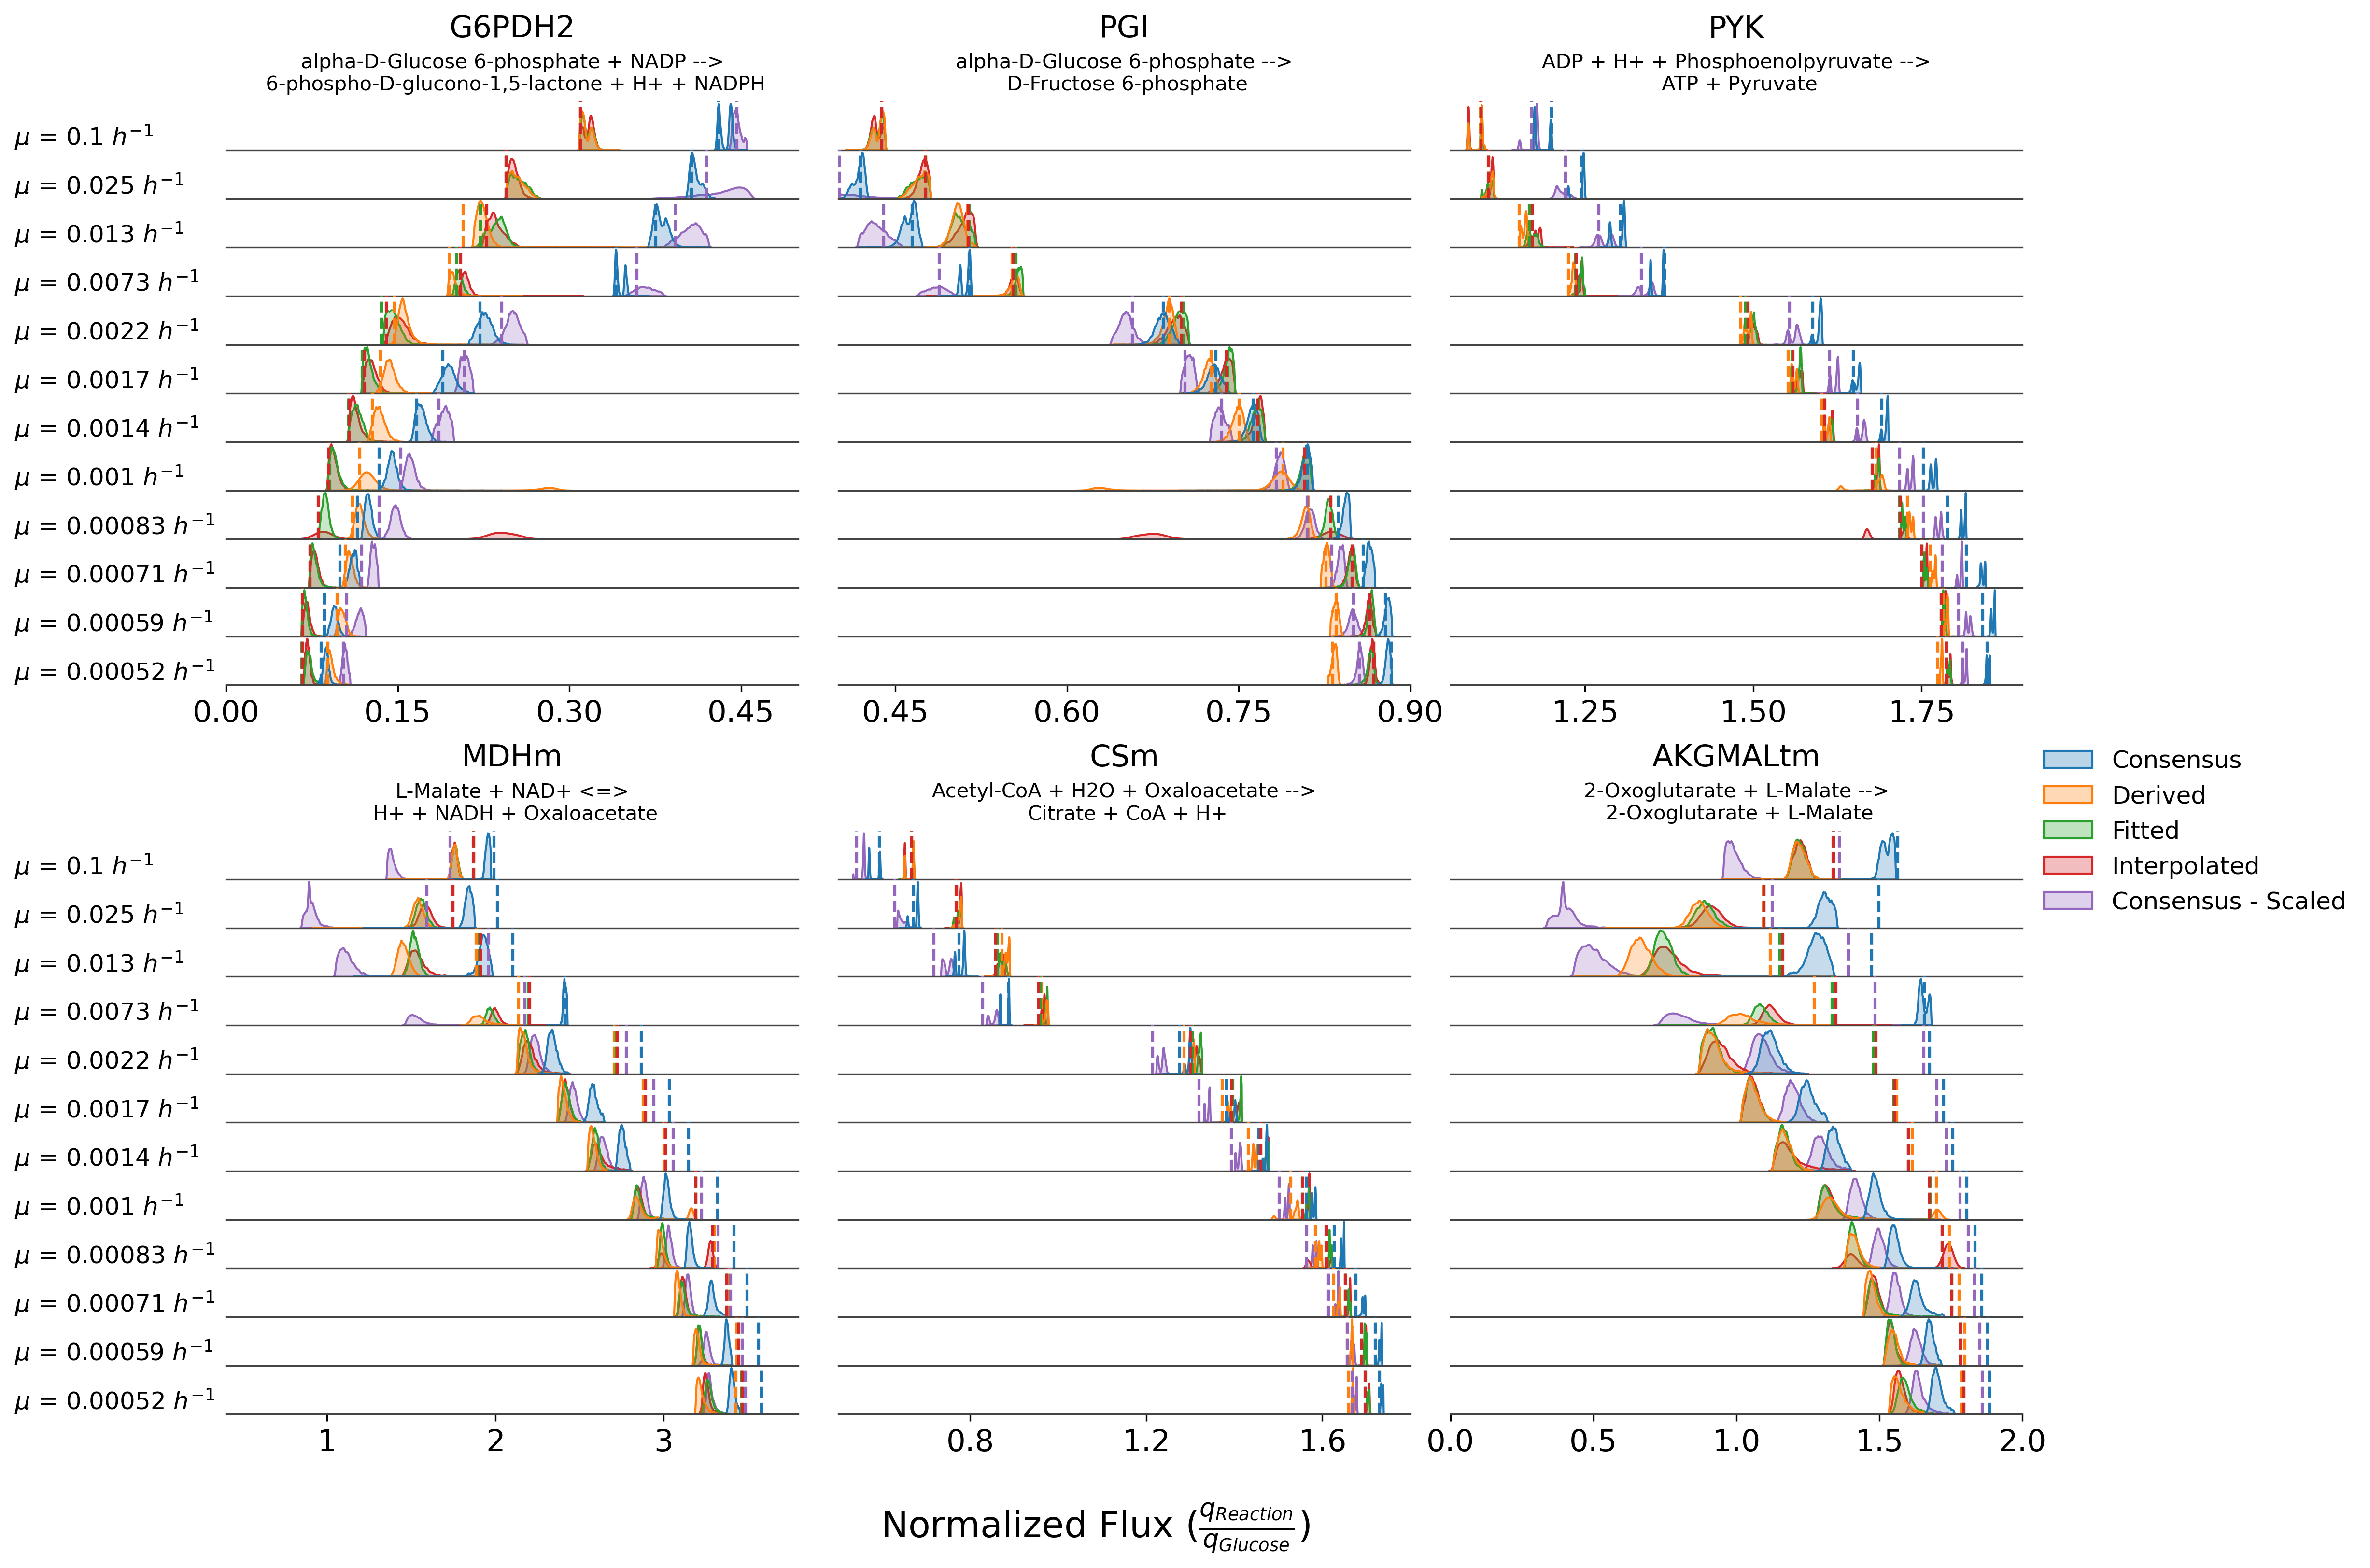

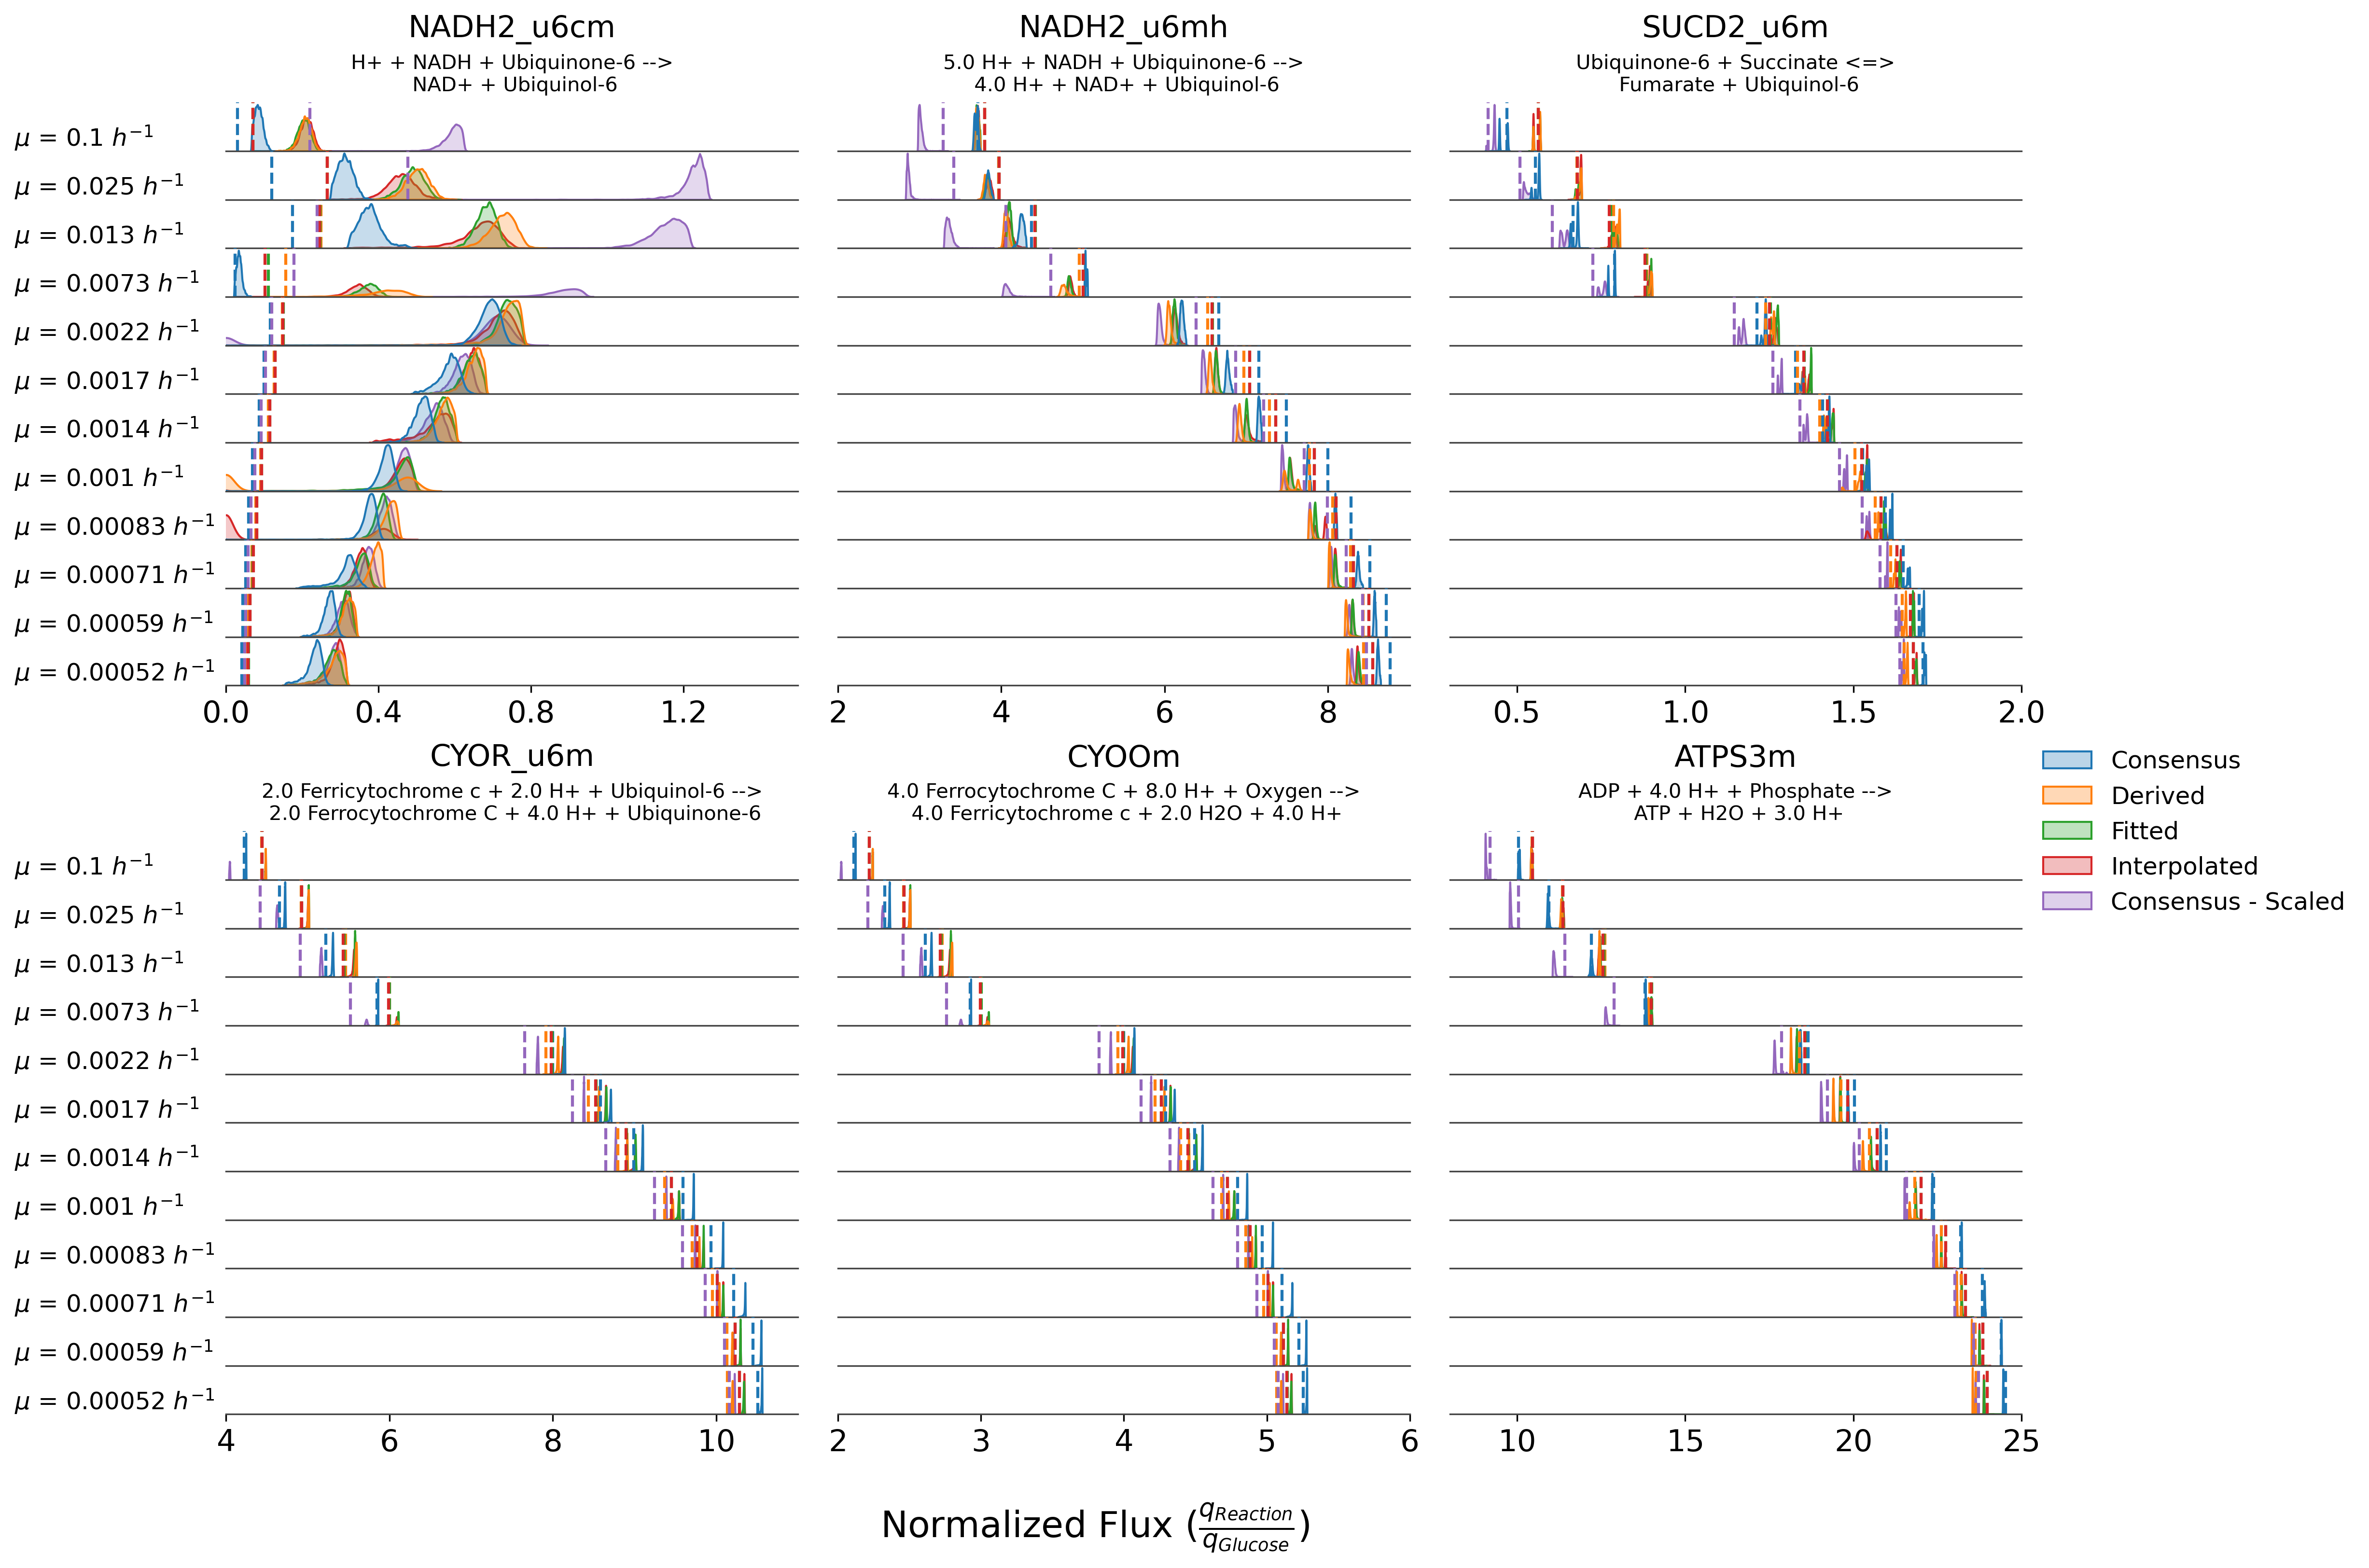

In [16]:
equation_names = ["Consensus","Derived", "Fitted", "Interpolated","ScaledConsensus"]

interesting_reactions = [("G6PDH2",0,0.5), ("PGI",0.4,0.9),("PYK",1.05,1.9),
                         ("MDHm", 0.4,3.8),("CSm", 0.5,1.8), ("AKGMALtm",0,2)]

plot_6_ridge(norm_chains_df, norm_pfba, interesting_reactions,"Gly&PPP", equation_names, model)

interesting_reactions = [("NADH2_u6cm",0,1.5),("NADH2_u6mh",2,9),("SUCD2_u6m",0.3,2),
                         ("CYOR_u6m", 4,11),("CYOOm", 2,6),("ATPS3m", 8,25)]

plot_6_ridge(norm_chains_df, norm_pfba, interesting_reactions,"ETC",equation_names, model)


##### Plot cofactor production fluxes

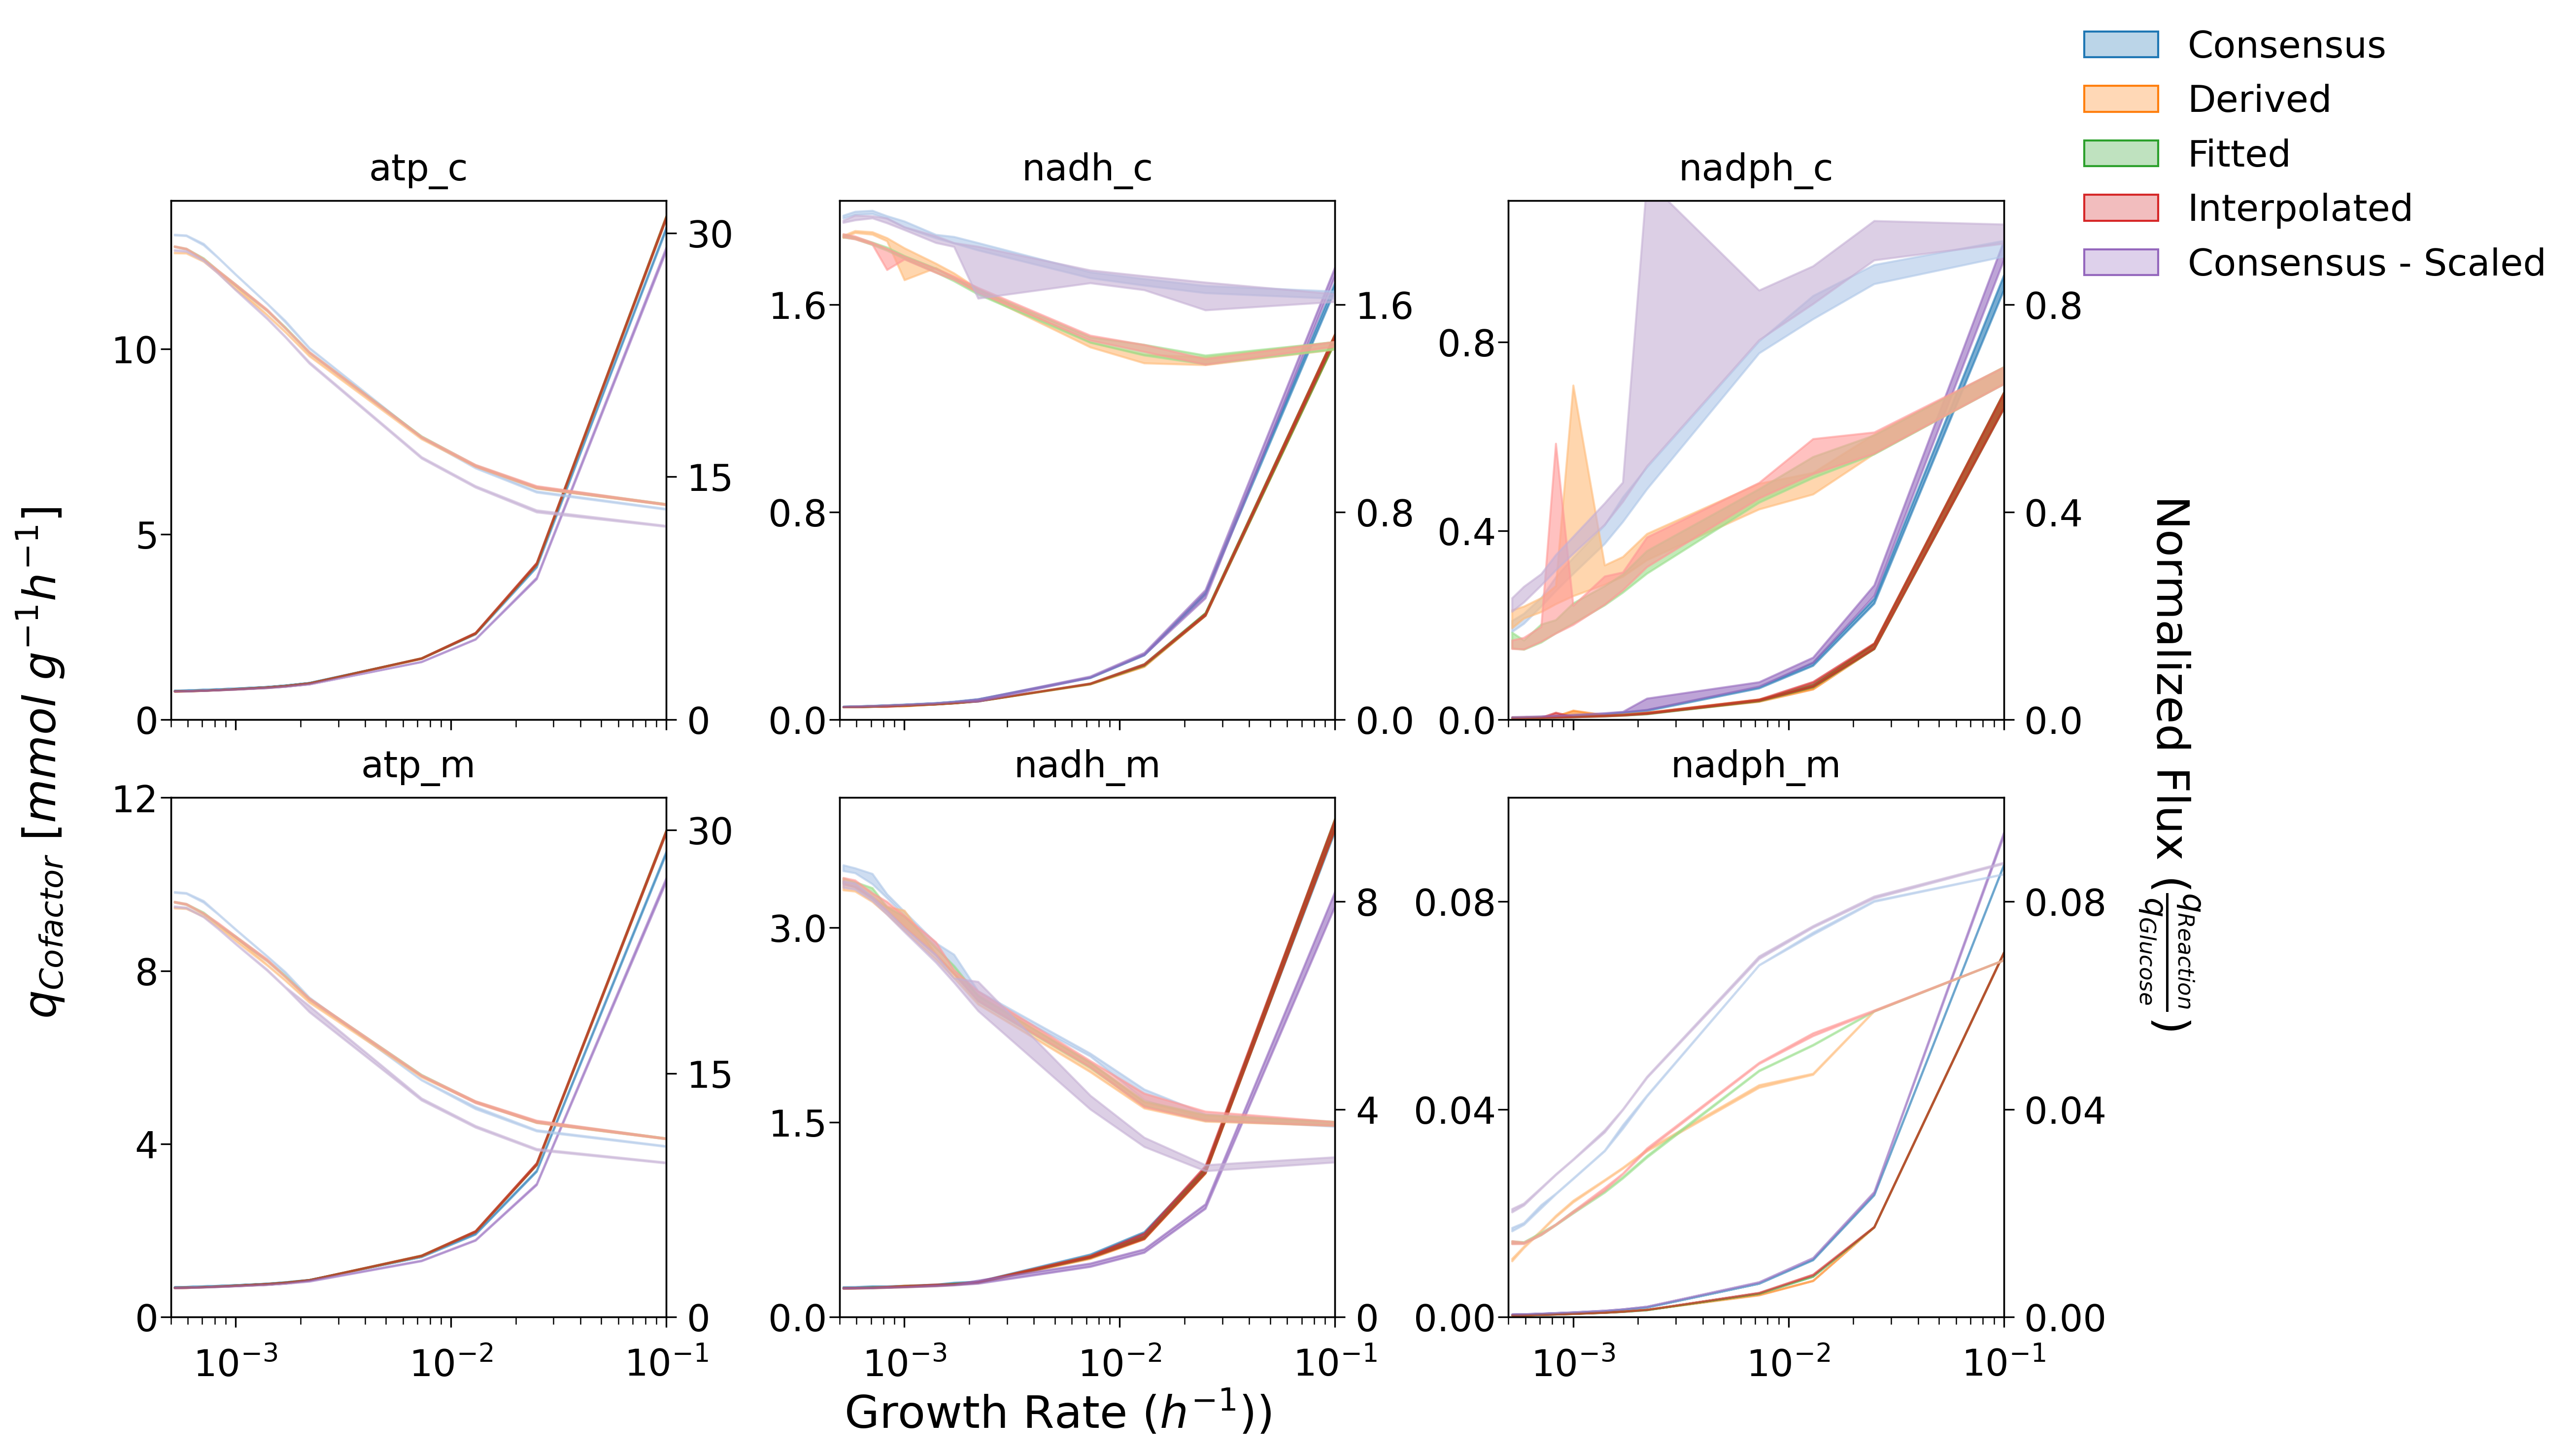

In [17]:
equation_names =  ["Consensus","Derived", "Fitted", "Interpolated","ScaledConsensus"]

interested_cofactors = [('atp_c',(0,14),(0,32)), 
                        ('nadh_c',(0,2),(0,2)), 
                        ('nadph_c', (0,1.1),(0,1)), 
                        ('atp_m', (0,12),(0,32)),
                        ('nadh_m', (0,4),(0,10)), 
                        ('nadph_m', (0,0.1),(0,0.1))]

fig, axs = plt.subplots(nrows=2, ncols=3, figsize=(16,10),dpi=300, sharex="col") # ) # 

cmap = plt.cm.get_cmap('tab20', 20)
color_list = [matplotlib.colors.rgb2hex(cmap(i)[:3]) for i in range(cmap.N)]

for i, (cof, ax_lims, ax2_lims) in enumerate(interested_cofactors):
    norm_slice = cofactors_norm_ranges.loc[cof]
    total_slice = cofactors_ranges.loc[cof]

    if i > 2:
        ax = axs[1,i-3]
    else:
        ax = axs[0,i]
    
    ax.set_xscale("log")
    ax2 = ax.twinx()
    
    for j, biomass in enumerate(equation_names):
        
        x = total_slice.columns.astype(float)
        uy = total_slice.loc[(biomass, 0.975),:]  # 0.9875),:] 
        ly = total_slice.loc[(biomass, 0.025),:]  #0.0125),:] 
        
        ax.fill_between(x, uy, ly,alpha=0.6, color=color_list[j*2], label=biomass, zorder=10)

        uy = norm_slice.loc[(biomass, 0.975),:]  # 0.9875),:] 
        ly = norm_slice.loc[(biomass, 0.025),:] # 0.0125),:] 
        ax2.fill_between(x, uy, ly,alpha=0.6, color=color_list[1+j*2], label=biomass)
    
    ax.set_ylabel("")
    ax2.set_ylabel("")

    ax.set_xlabel("", fontsize=40, labelpad=20)
    
    ax.tick_params("y", labelsize=18, pad=1, length=5)
    ax.tick_params("x", labelsize=18, pad=10, length=5)
    ax.tick_params(which="minor",length=3.5)
    ax2.tick_params(labelsize=18, pad=5, length=5)
    
    ax.set_title(cof, fontsize=18,pad=10)
    ax.yaxis.set_major_locator(MaxNLocator(3))
    ax2.yaxis.set_major_locator(MaxNLocator(3))

   
    ax.set_xlim(0.0005,0.1)
    ax.set_ylim(ax_lims)
    ax2.set_ylim(ax2_lims)
    
plt.subplots_adjust(wspace=0.35, hspace=0.15) #hspace=0.25)


labels = [eqn if not eqn == "ScaledConsensus" else "Consensus - Scaled" for eqn in equation_names]       
legend_elements = [mpatches.Patch(edgecolor=cmap(i*2), label=eqn, facecolor=cmap(i*2)[:-1] + (0.3,)) for i, eqn in enumerate(labels)]
legend = fig.legend(handles=legend_elements, loc='center left', bbox_to_anchor=(0.92,0.91), fontsize=18, frameon=False)

fig.text(0.07, 0.5, r'$q_{Cofactor}$ $[mmol\ g^{{-1}} h^{{-1}}]$', ha='center', va='center', fontsize=22,rotation=90)
fig.text(0.97, 0.5, r'Normalized Flux ($\frac{q_{Reaction}}{q_{Glucose}}$)', ha='center', va='center', fontsize=22,rotation=270)
fig.text(0.5, 0.06, r'Growth Rate ($h^{-1})$)', ha='center', va='center', fontsize=22)

fig.savefig(f"../results/plots/Mu_vs_Cofactors.png",
            bbox_inches='tight',transparent=True)

##### Plot gas exchanges 

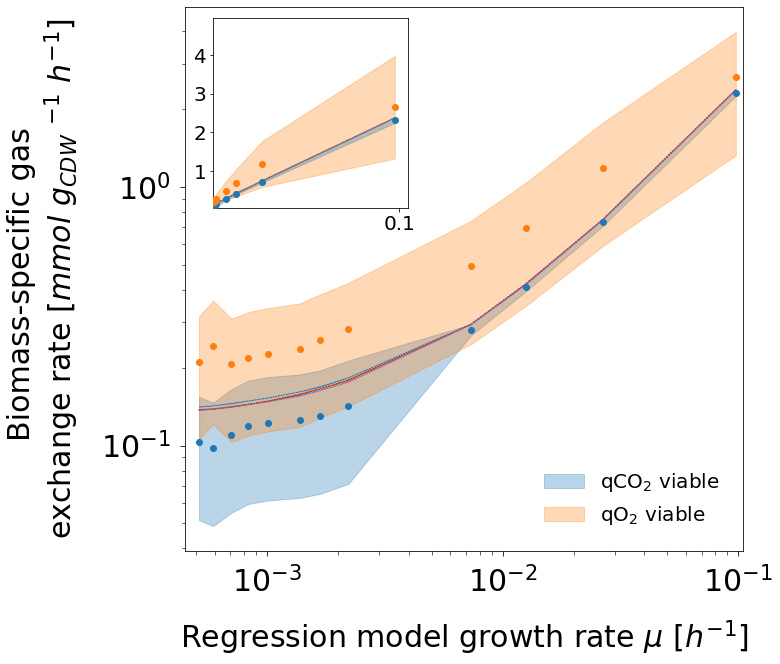

In [18]:
cmap = plt.cm.get_cmap('tab10', 10)
color_list = [matplotlib.colors.rgb2hex(cmap(i)[:3]) for i in range(cmap.N)]

fig, ax = plt.subplots(figsize=(10,10))
ax.set_xscale("log")
ax.set_yscale("log")


x, y_co2, y_co2_sd, y_o2, y_o2_sd = DRinfo.loc[:, [("Growth Rate model 1/h", "mean"),
                                                    ("qCO2 viable model mmol/gh", "mean"),
                                                    ("qCO2 viable model mmol/gh", "std"),
                                                    ("qO2 viable model mmol/gh", "mean"),
                                                    ("qO2 viable model mmol/gh", "std")]].values.T
                    
      
ax.scatter(x,y_co2, c=color_list[0],zorder=10)
ax.fill_between(x, y_co2+y_co2_sd, y_co2-y_co2_sd, alpha=0.3, color=color_list[0], label="qCO$_2$ viable")

ax.scatter(x,y_o2, c=color_list[1],zorder=10)
ax.fill_between(x, y_o2+y_o2_sd, y_o2-y_o2_sd, alpha=0.3, color=color_list[1], label="qO$_2$ viable")      

ax.set_xlim(4.5e-4,0.105)

ax.set_xlabel('Regression model growth rate $\mu\ [h^{-1}]$', fontsize=30, labelpad=20)
ax.set_ylabel('Biomass-specific gas \nexchange rate $[mmol\ g_{CDW}\ ^{-1}\ h^{-1}$]', fontsize=30,labelpad=20)
ax.tick_params(labelsize=30, pad=10, length=5)
ax.tick_params(which="minor",length=3.5)

axins = ax.inset_axes([0.05, 0.63, 0.35, 0.35])

axins.scatter(x,y_co2, c=color_list[0],zorder=10)
axins.fill_between(x, y_co2+y_co2_sd, y_co2-y_co2_sd, alpha=0.3, zorder=10, color=color_list[0])

axins.scatter(x,y_o2,  c=color_list[1],zorder=10)
axins.fill_between(x, y_o2+y_o2_sd, y_o2-y_o2_sd, alpha=0.3, zorder=0, color=color_list[1])

for i, rxn in enumerate(["Ex_co2"]):
    
        
    for j, bio in enumerate(equation_names):

        col = color_list[i+j]
        
        ranges = quants.loc[bio].sort_index(level=1,ascending=False).abs()
        
        ax.fill_between(x,
                        ranges.loc[:,(rxn, 0.025) ],
                        ranges.loc[:,(rxn, 0.975) ],
                        alpha=1, zorder=5, color=col, linestyle=":",edgecolors=col)
    
        axins.fill_between(x,
                        ranges.loc[:,(rxn, 0.025) ],
                        ranges.loc[:,(rxn, 0.975) ],
                        alpha=0.6, zorder=5, color=col, linestyle=":",edgecolors=col)

axins.set_xlim(ax.get_xlim())#[0,0.1])
axins.set_ylim(ax.get_ylim())#[0,3])
axins.xaxis.set_major_locator(MultipleLocator(0.1))
axins.yaxis.set_major_locator(MultipleLocator(1))

axins.tick_params(labelsize=20)


# if log:
ax.legend(loc='lower right',bbox_to_anchor=(0.99,0.01), frameon=False, 
      fontsize='small',prop={'size':20})


fig.savefig(f"../results/plots/Mu_vs_Gas_sampled.png",
        bbox_inches='tight',transparent=True)

#### Statistical comparisons 
- significant differences between biomass equation generation methods & at different growth rates
Use 1000 samples instead of the 5000 to reduce computational time

In [19]:
%%time

all_sp_stats_norm = pd.DataFrame()

data = DRinfo.loc[:,model_viab_cols]

comparisons = [("Consensus","ScaledConsensus"), ("Consensus","Derived"), ("Consensus", "Interpolated"), ("Consensus", "Fitted"),
               ("ScaledConsensus","Derived"), ("ScaledConsensus", "Interpolated"), ("ScaledConsensus", "Fitted"),
               ("Interpolated", "Derived"), ("Interpolated", "Fitted"),
               ("Derived", "Fitted")]


for comp in comparisons:

    first, second = comp
    
    comp_stats = []

    for name, values in data.iterrows():
        
        start = time.time()

        name = str(name)
        mu = values[0]
        df1 = pd.read_pickle(f"../results/sampling/{first}_{name}_T{optthin}.pkl.gz")
        df2 = pd.read_pickle(f"../results/sampling/{second}_{name}_T{optthin}.pkl.gz")

    
        shared_columns = list(set(df1.columns).intersection(df2.columns))
        df1 = df1.loc[:,shared_columns] 
        df2 = df2.loc[:,shared_columns] 

        mask = (df1.sum(axis=0) == 0)&(df1.sum(axis=0) == df2.sum(axis=0))
        
        df1 = df1.loc[:, ~mask]
        df2 = df2.loc[:, ~mask]
        
        df1 = df1.sample(1000)
        df2 = df2.sample(1000)

        rxn_names = df1.columns
        n_rxns = len(rxn_names) ### CHeck both have same number each time
        yield_rxn = 'Ex_glc_D'

        ix = df1.columns.get_loc(yield_rxn)
        
        df1 = df1.values
        df2 = df2.values
        

        rel_df1 = df1 * np.abs(1/df1[:,[ix]])
        rel_df2 = df2 * np.abs(1/df2[:,[ix]])

        index = pd.MultiIndex.from_product([[name], rxn_names])
        sp_stats = pd.DataFrame(columns = ['Reaction','U-val', 'M P-value', 'RBC', 'CLES', 'Rhat', 'VD-A', 'VD Magnitude',"Cliff's D"])

        for_pool = []
        for i in np.arange(0,n_rxns):
            rxn_name = rxn_names[i]
            col_df1 = rel_df1[:,i]
            col_df2 = rel_df2[:,i]
            for_pool.append([col_df1, col_df2, rxn_name])
        

        pool = Pool(processes=processes)
        all_series = pool.starmap(calcstats, for_pool)
        pool.close()
        
        sp_stats = pd.concat(all_series,axis=1).T
        
        reject, adj_p, alpha_sid, alpha_bon = multipletests(np.abs(sp_stats["M P-value"].values), method="bonferroni",alpha=0.05/2) ## two tailed, so divide by 2
        sp_stats["Reject"] = reject
        sp_stats["Adjusted-p"] = adj_p.astype(float)
        sp_stats["M P-value"] = sp_stats["M P-value"].astype(float)
        sp_stats["Growth Rate"] = sp_gr[name]
        # sp_stats["Sampling Point"] = name
        
        comp_stats.append(sp_stats)
    comp_df = pd.concat(comp_stats)
    comp_df["Comparisons"] = f"{first} vs {second}"
    # comp_df.set_index(["Comparisons", "Sampling Point","Reaction"], inplace=True)
    comp_df.set_index(["Comparisons", "Growth Rate","Reaction"], inplace=True)
        
        
    all_sp_stats_norm = all_sp_stats_norm.append(comp_df)
# all_sp_stats_norm.index.get_level_values("Sampling Point")
all_sp_stats_norm["Reaction Number"] = all_sp_stats_norm.groupby("Growth Rate").cumcount() + 1   
# all_sp_stats_norm["Reaction Number"] = all_sp_stats_norm.groupby("Sampling Point").cumcount() + 1   
all_sp_stats_norm["Abs Cliff's D"] = all_sp_stats_norm["Cliff's D"].abs()
all_sp_stats_norm["Rxn Subsystem"] = all_sp_stats_norm.index.get_level_values("Reaction").to_series().apply(lambda x: rgdict.get(x)).values
all_sp_stats_norm.to_csv(f"../results/dataframes/sampling/MethodComparisons_AllStatistics.csv")

CPU times: user 2min 15s, sys: 7min 5s, total: 9min 20s
Wall time: 9min 25s


Median percentage of reactions differing across all comparisons

In [20]:
# rejects = all_sp_stats_norm.groupby(["Comparisons", "Sampling Point"])["Reject"].sum()#["Reject"]
# total_group = all_sp_stats_norm.groupby(["Comparisons", "Sampling Point"]).count().values[:,0]
rejects = all_sp_stats_norm.groupby(["Comparisons", "Growth Rate"])["Reject"].sum()#["Reject"]
total_group = all_sp_stats_norm.groupby(["Comparisons", "Growth Rate"]).count().values[:,0]
rejects = (rejects/total_group).to_frame().unstack()
print(f"Average of {round(100*rejects.stack().median().values[0],1)}% of reactions significantly differently dsitributed")
rejects.to_csv(f"../results/dataframes/sampling/MethodComparisons_MWURejects.csv")
rejects

Average of 72.6% of reactions significantly differently dsitributed


Reject                                \
Growth Rate                       0.00052   0.00059   0.00071   0.00083   
Comparisons                                                               
Consensus vs Derived             0.667462  0.746935  0.696203  0.684956   
Consensus vs Fitted              0.669967  0.699830  0.721137  0.715278   
Consensus vs Interpolated        0.700168  0.707274  0.738448  0.675903   
Consensus vs ScaledConsensus     0.681818  0.667231  0.690355  0.726222   
Derived vs Fitted                0.640777  0.705683  0.689744  0.730427   
Interpolated vs Derived          0.645528  0.715278  0.703544  0.659847   
Interpolated vs Fitted           0.656522  0.604348  0.663073  0.666382   
ScaledConsensus vs Derived       0.654560  0.707012  0.710833  0.712329   
ScaledConsensus vs Fitted        0.707942  0.708547  0.724409  0.701707   
ScaledConsensus vs Interpolated  0.686156  0.701544  0.686477  0.680687   

                                                                         \
Growth Rate                         0.001    0.0014    0.0017    0.0022   
Comparisons                                                               
Consensus vs Derived             0.712794  0.747232  0.740092  0.747243   
Consensus vs Fitted              0.725333  0.702653  0.759003  0.738028   
Consensus vs Interpolated        0.760000  0.725314  0.723721  0.750923   
Consensus vs ScaledConsensus     0.702338  0.761194  0.730589  0.721659   
Derived vs Fitted                0.759649  0.690346  0.743913  0.684893   
Interpolated vs Derived          0.778369  0.724599  0.745931  0.726449   
Interpolated vs Fitted           0.614004  0.599644  0.684752  0.730516   
ScaledConsensus vs Derived       0.734099  0.752799  0.747938  0.746582   
ScaledConsensus vs Fitted        0.736937  0.730841  0.767658  0.728200   
ScaledConsensus vs Interpolated  0.753623  0.723577  0.781716  0.769510   

                                                                         
Growth Rate                        0.0073     0.013     0.025       0.1  
Comparisons                                                              
Consensus vs Derived             0.800763  0.773036  0.802220  0.810398  
Consensus vs Fitted              0.724036  0.777998  0.788746  0.782518  
Consensus vs Interpolated        0.743867  0.760199  0.762763  0.789144  
Consensus vs ScaledConsensus     0.810628  0.737452  0.772812  0.781377  
Derived vs Fitted                0.760267  0.677757  0.736630  0.605634  
Interpolated vs Derived          0.792417  0.736434  0.464832  0.702840  
Interpolated vs Fitted           0.695050  0.717092  0.490040  0.683230  
ScaledConsensus vs Derived       0.740150  0.805158  0.776190  0.747809  
ScaledConsensus vs Fitted        0.798834  0.775763  0.787850  0.744000  
ScaledConsensus vs Interpolated  0.815459  0.742690  0.780374  0.741775

- Percentage of reactions that had a large effect size in a comparison
Note, that between 5% and 10% of reactions had a large effect size for the C0.1 and 0.0 sampling points for the Derived, Fitted and Inteprolated despite the fact the biomass equation is the same. This is largely due to random smapling effecs

In [21]:
# large = (all_sp_stats_norm["VD Magnitude"] == "large").groupby(["Comparisons", "Sampling Point"]).sum()
large = (all_sp_stats_norm["VD Magnitude"] == "large").groupby(["Comparisons", "Growth Rate"]).sum()
large = (large/total_group).to_frame().unstack()
print(f"Average of {round(100*large.stack().median().values[0],1)}% of reactions demonstrate a large effect size")
large.to_csv(f"../results/dataframes/sampling/MethodComparisons_LargeEffects.csv")
large

Average of 46.8% of reactions demonstrate a large effect size


VD Magnitude                                \
Growth Rate                          0.00052   0.00059   0.00071   0.00083   
Comparisons                                                                  
Consensus vs Derived                0.436754  0.454466  0.452321  0.452212   
Consensus vs Fitted                 0.448020  0.431973  0.463588  0.453125   
Consensus vs Interpolated           0.417923  0.443471  0.455972  0.449202   
Consensus vs ScaledConsensus        0.424242  0.441152  0.478849  0.478222   
Derived vs Fitted                   0.409385  0.446989  0.447009  0.440391   
Interpolated vs Derived             0.405691  0.452257  0.448574  0.436488   
Interpolated vs Fitted              0.306957  0.253913  0.287511  0.331911   
ScaledConsensus vs Derived          0.428571  0.421536  0.464167  0.456621   
ScaledConsensus vs Fitted           0.444919  0.469231  0.484689  0.462713   
ScaledConsensus vs Interpolated     0.394669  0.462264  0.470284  0.425751   

                                                                         \
Growth Rate                         0.001    0.0014    0.0017    0.0022   
Comparisons                                                               
Consensus vs Derived             0.470844  0.511993  0.493088  0.458640   
Consensus vs Fitted              0.475556  0.483074  0.485688  0.478873   
Consensus vs Interpolated        0.487111  0.466786  0.509767  0.488930   
Consensus vs ScaledConsensus     0.469424  0.471082  0.489242  0.459908   
Derived vs Fitted                0.465789  0.463570  0.441839  0.440222   
Interpolated vs Derived          0.476950  0.453654  0.482821  0.398551   
Interpolated vs Fitted           0.284560  0.282918  0.433115  0.400000   
ScaledConsensus vs Derived       0.481449  0.486940  0.496792  0.491340   
ScaledConsensus vs Fitted        0.475676  0.465421  0.497212  0.509276   
ScaledConsensus vs Interpolated  0.469203  0.456188  0.501866  0.510889   

                                                                         
Growth Rate                        0.0073     0.013     0.025       0.1  
Comparisons                                                              
Consensus vs Derived             0.515729  0.564500  0.558022  0.586137  
Consensus vs Fitted              0.523244  0.548067  0.544916  0.573361  
Consensus vs Interpolated        0.528950  0.547264  0.546547  0.582463  
Consensus vs ScaledConsensus     0.525604  0.528958  0.538175  0.551619  
Derived vs Fitted                0.438395  0.466730  0.088799  0.129779  
Interpolated vs Derived          0.478673  0.487403  0.075433  0.133874  
Interpolated vs Fitted           0.425743  0.399804  0.124502  0.066253  
ScaledConsensus vs Derived       0.514071  0.540592  0.553333  0.529698  
ScaledConsensus vs Fitted        0.543246  0.521947  0.560748  0.554000  
ScaledConsensus vs Interpolated  0.550725  0.528265  0.557009  0.526421

##### Enrichment analysis on the different subsystems to determine where the significant changes occured

In [22]:
rgdict = {}
for g in model.groups:
    for r in g.members:
        rgdict[r.id] = g.id.title()
        
subsystem_df = pd.DataFrame.from_dict(rgdict, orient="index").reset_index()
subsystem_df = subsystem_df.rename(columns={"index":"Rxn", 0:"Subsystem"})



In [23]:
all_output = []


for comparison in large.index:
    for sp in large.columns.get_level_values(1):
        
        ## using enrich function in CBModellingFuncs
        temp = all_sp_stats_norm.loc[(comparison, sp),"VD Magnitude"]
        output = enrich(temp[temp == "large"].index, subsystem_df["Rxn"].to_list(), subsystem_df) 
        if comparison == f"{first} vs {second}" and sp ==name:
            save = output
        all_output.extend(output.loc[output["adj_pval"] < 0.05, "Subsystem annotation"].to_list())
        
number_enriched = pd.Series(all_output).value_counts().to_frame().rename(columns={0:"Counts"})
number_enriched["Fraction"] = number_enriched["Counts"]/(large.shape[0]*large.shape[1])

number_enriched.to_csv(f"../results/dataframes/sampling/MethodComparisons_EnrichedPathways.csv")

number_enriched

/home/users/bcoltman/.conda/envs/memo3.7/lib/python3.7/site-packages/pandas/core/indexing.py:925: PerformanceWarning: indexing past lexsort depth may impact performance.
  return self._getitem_tuple(key)


### Additional analysis
- Not included in manuscript

##### Alternative plot of the 12 reactions. Flux yields and flux vs growth rate

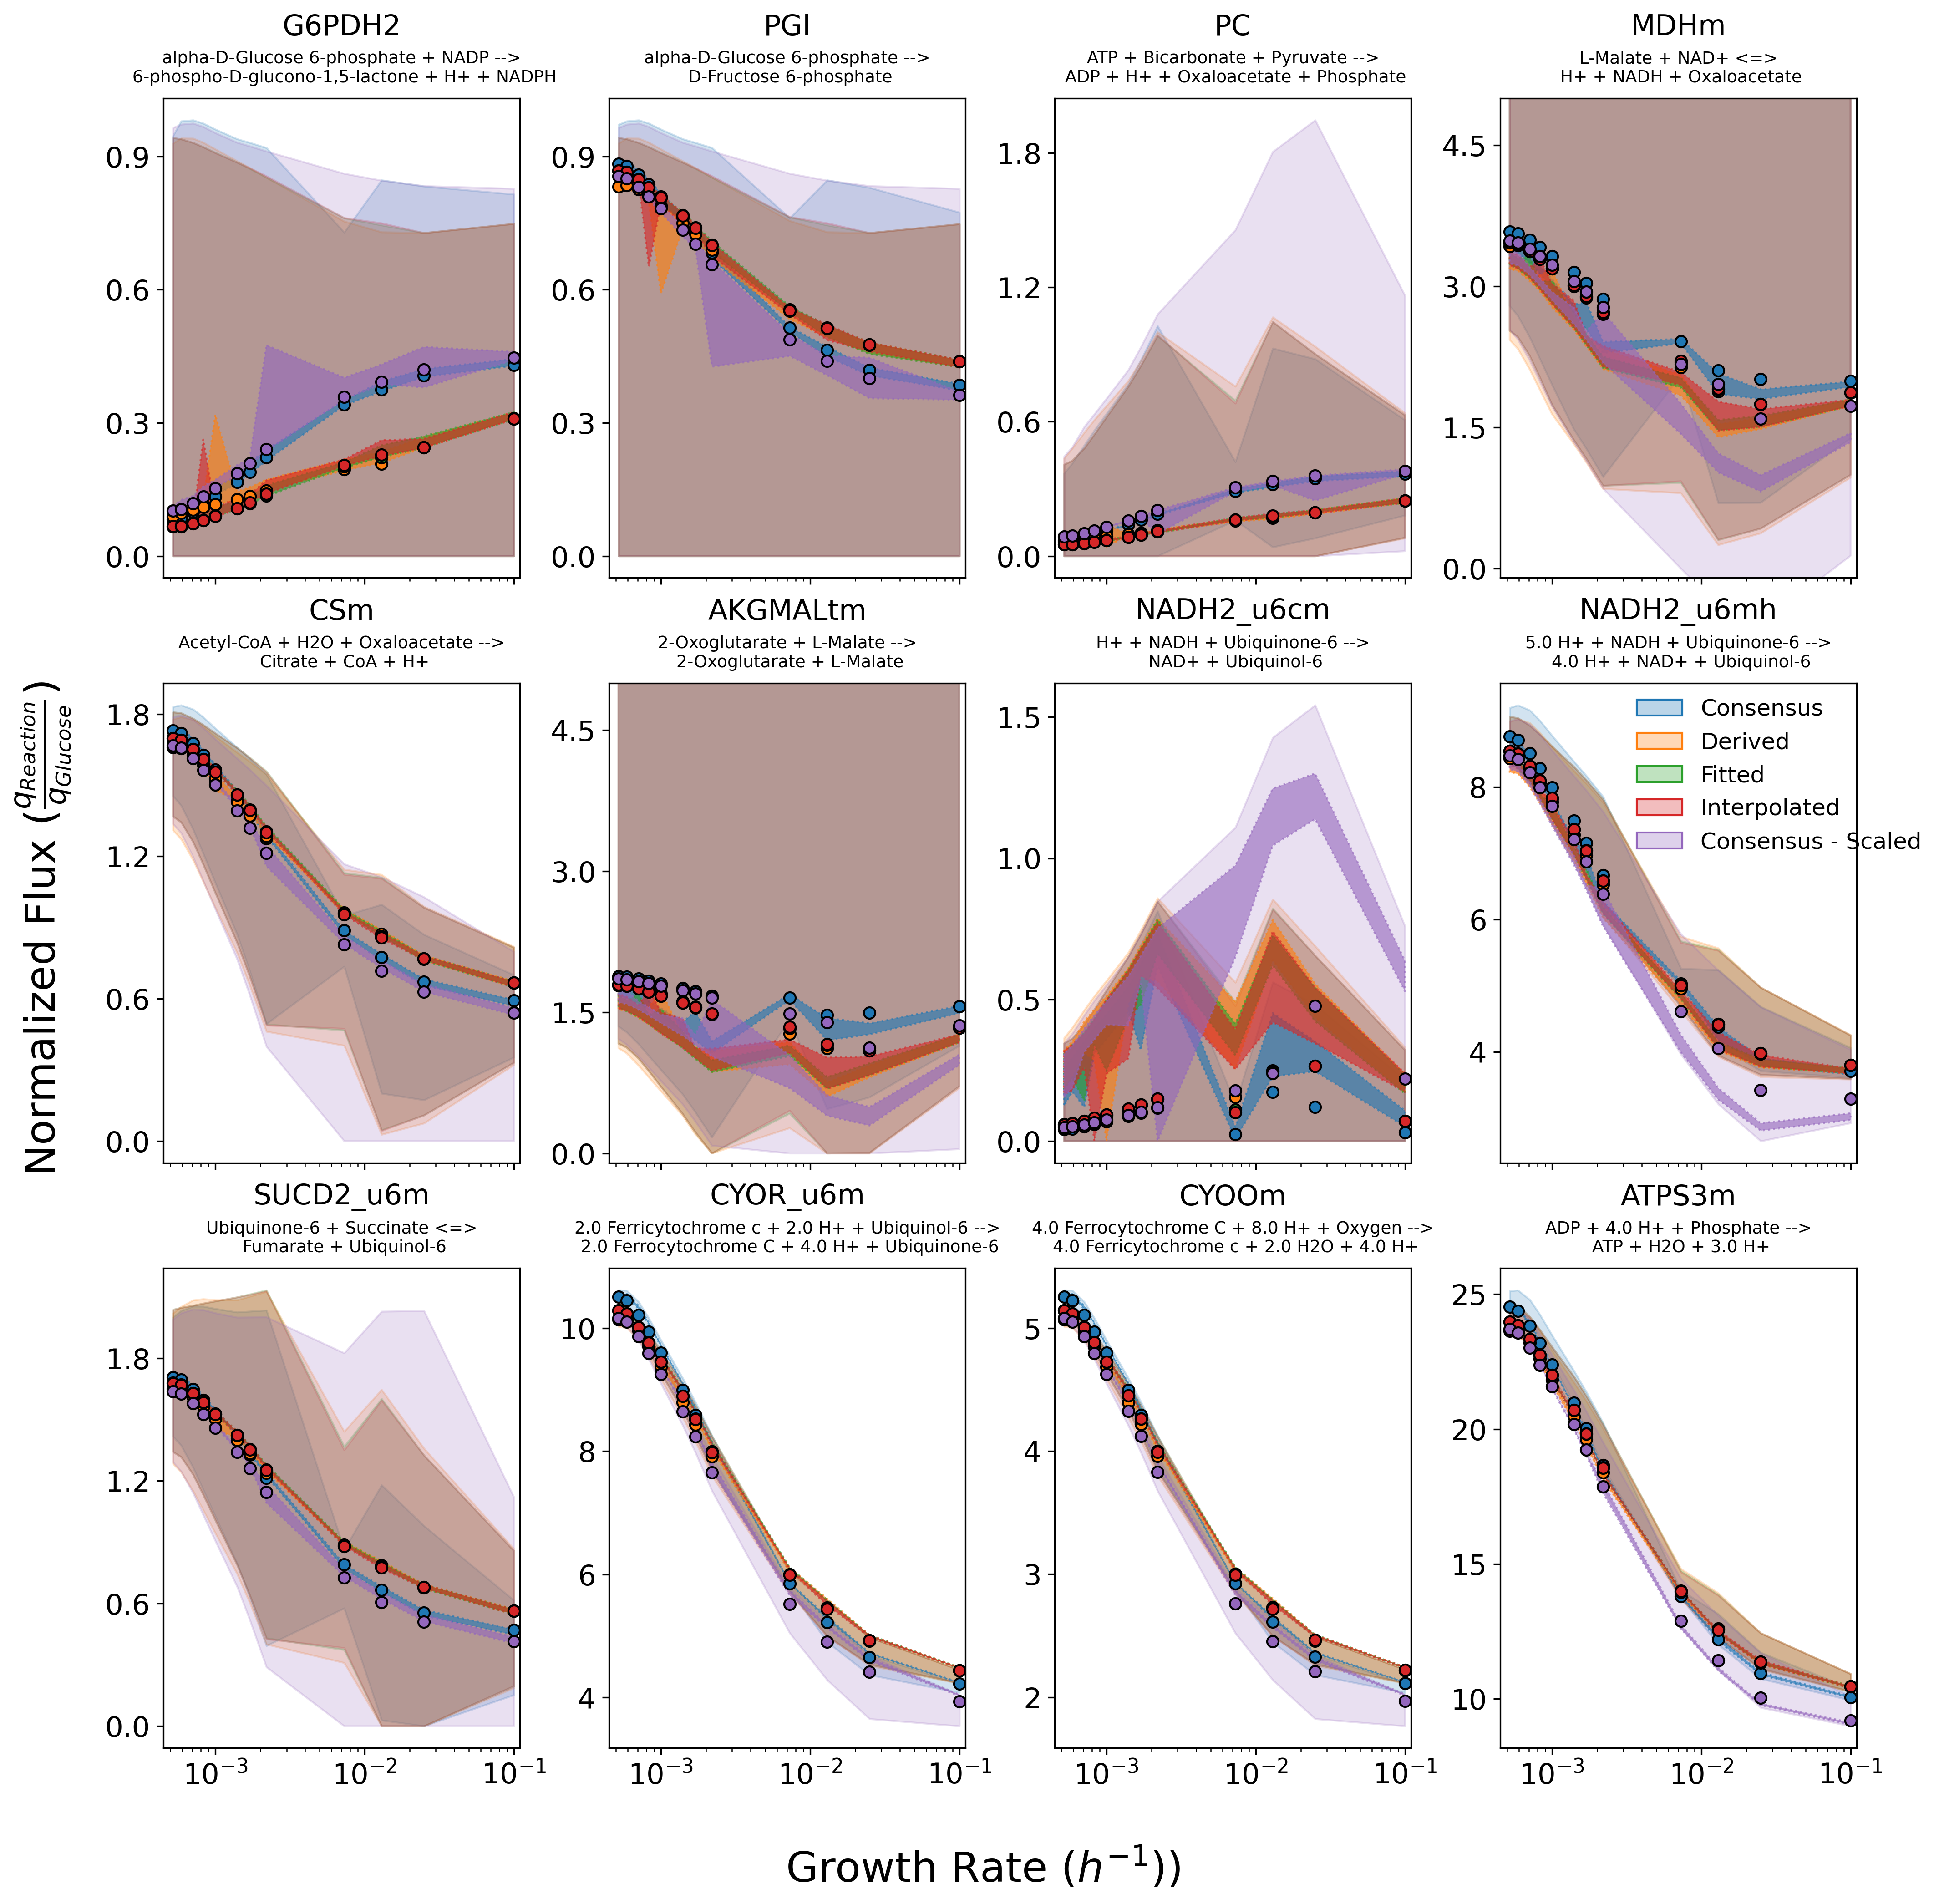

In [25]:
def plot_12_reactions(interesting_reactions,out_name,biomass_equations, quants, fva, pfba):
    
    number_sps = len(quants.index.get_level_values("Time").unique()) #norm_chains.Time.unique())

    fig, axs = plt.subplots(nrows=3, ncols=4, figsize=(16,16),dpi=300, sharex="col") # ) # 

    cmap = plt.cm.get_cmap('tab10', 10)
    color_list = [matplotlib.colors.rgb2hex(cmap(i)[:3]) for i in range(cmap.N)]

    for i, (rxn,lb,ub) in enumerate(interesting_reactions):

        if i < 4:
            ax = axs[0,i]
        elif i < 8:
            ax = axs[1,i-4]
        else:
            ax = axs[2,i-8]
            
        plotting_fluxes(ax, rxn, quants, fva, pfba,color_list=color_list,biomass=biomass_equations)
        ax.set_xscale("log")
        if rxn in ["AKGMALtm", "MDHm"]:
            ax.set_ylim(-0.1, 5)
        # ax.set_ylim(lb, ub)
        ax.set_xlim(4.5e-4,0.11)
        from matplotlib.ticker import MultipleLocator, MaxNLocator
        ax.yaxis.set_major_locator(MaxNLocator(4))

        string = model.reactions.get_by_id(rxn).build_reaction_string(True)
        if string.find(">") > -1:
            string = string.split(">")
            string = (">\n").join(string)
        elif string.rfind("-") > -1:
            string = string.rsplit("-",1)
            string = ("-\n").join(string)


        ax.set_xlabel("")
        ax.tick_params(labelsize= 15)

        ax.text(0.5, 1.12, rxn, fontsize=15, transform = ax.transAxes,horizontalalignment='center',verticalalignment='bottom') 
        ax.text(0.5, 1.1, string, fontsize=9, transform = ax.transAxes,horizontalalignment='center',verticalalignment='top')  
        

    import matplotlib.patches as mpatches
    plt.subplots_adjust(wspace=0.25, hspace=0.22) #hspace=0.25)


    legend_elements = [mpatches.Patch(edgecolor=cmap(k), label=eqn if not eqn == "ScaledConsensus" else "Consensus - Scaled", 
                                      facecolor=cmap(k)[:-1] + (0.3,)) for k, eqn in enumerate(biomass_equations)]
   
    legend = fig.legend(handles=legend_elements, loc='center left', bbox_to_anchor=(0.79,0.57), fontsize=12, frameon=False)

    fig.text(0.07, 0.5, r'Normalized Flux ($\frac{q_{Reaction}}{q_{Glucose}}$)', ha='center', va='center', fontsize=22,rotation=90)
    fig.text(0.5, 0.07, r'Growth Rate ($h^{-1})$)', ha='center', va='center', fontsize=22)

    fig.savefig(f"../results/plots/FluxYieldAll.png",
            bbox_inches='tight',transparent=True)  
    
def plotting_fluxes(ax,rxn, sampling_data, fva_data, pfba_data, color_list=None, biomass=None):
    if biomass == None:
        biomass = ["Dynamic", "Consensus"]
    elif type(biomass) != list:
        biomass = list(biomass)
    
    if color_list == None:
        cmap = plt.cm.get_cmap('tab10', 10)
        color_list = [matplotlib.colors.rgb2hex(cmap(i)[:3]) for i in range(cmap.N)]
    
    
    for i, bio in enumerate(biomass):
        
        col = color_list[i]
        
        fva_ranges = fva_data.loc[bio].sort_index(level=1)
        samples = sampling_data.loc[bio].sort_index(level=1)
        flux = pfba_data.loc[bio].sort_index(level=1)
        
        ax.fill_between(fva_ranges.index.get_level_values("Growth Rate").astype(float),
                        fva_ranges.loc[:,(rxn, "minimum") ],
                        fva_ranges.loc[:,(rxn, "maximum") ],
                        alpha=0.2,zorder=0, color=col)
        
        ax.fill_between(samples.index.get_level_values("Growth Rate").astype(float),
                        samples.loc[:,(rxn, 0.025) ],
                        samples.loc[:,(rxn, 0.975) ],
                        alpha=0.6, zorder=5, color=col, linestyle=":",edgecolors=col)
        
        ax.scatter(flux.loc[:,rxn].index.get_level_values("Growth Rate").astype(float),
                   flux.loc[:,rxn],zorder=10, color=col, edgecolors="black")


interesting_reactions = [("G6PDH2",0,0.5), ("PGI",0.4,0.9),("PC",0,1),
                         ("MDHm", 0.4,3.8),("CSm", 0.5,1.8), ("AKGMALtm",0,2),
                         ("NADH2_u6cm",0,1.5),("NADH2_u6mh",2,9),("SUCD2_u6m",0.3,2),
                         ("CYOR_u6m", 4,11),("CYOOm", 2,6),("ATPS3m", 8,25)] 


plot_12_reactions(interesting_reactions,"All",equation_names, norm_quants, norm_fva,norm_pfba)


##### RQ plot

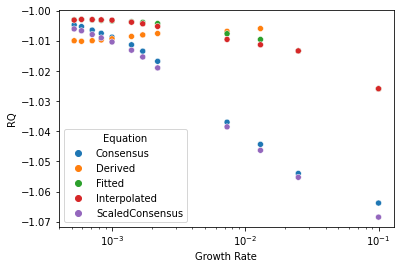

In [26]:
RQ = norm_chains_df["Ex_co2"].div(norm_chains_df["Ex_o2"])

fig, ax = plt.subplots()
to_plot = RQ.reset_index()
to_plot.rename(columns={0:"RQ"}, inplace=True)
to_plot = to_plot[to_plot["Equation"].isin(equation_names)]
to_plot["Growth Rate"] = to_plot["Growth Rate"].astype(float)
to_plot = to_plot.groupby(["Equation", "Growth Rate"]).median().reset_index()
sns.scatterplot(data=to_plot, x="Growth Rate",y="RQ",hue="Equation", hue_order=equation_names)
ax.set_xscale("log")

##### PCA analysis

Explained variation per principal component: [2.09501256e-01 6.36109168e-02 3.50730974e-02 ... 2.53013815e-35
 6.89866758e-36 4.31514491e-37]
Index(['PRPPS', 'CBPS', 'RNA', 'CTPS1', 'CHORM', 'RPI', 'ASPCT', 'DHORTS',
       'OMPDC', 'ORPT', 'IMPD', 'GMPS2', 'ADSL2r', 'PRASCS', 'AIRCr', 'PRFGS',
       'GLUPRT', 'GARFTi', 'PRAIS', 'PRAGSr', 'HSDxi', 'E3MMALOR', 'CITCONH',
       'E3MMALH', 'CITMALS', 'ASADi', 'ASPKi', '2OXOADPtim', 'Ex_nh4', 'NH4t',
       'Ex_pi', 'PIt2r', 'AGPRim', 'ACOTAim', 'ORNt3m', 'ACGKm', 'ORNTACim',
       'GLUDyi', 'HSK', 'THRS', 'ADSS', 'ADSL1r', 'OXAGm', 'HICITDm', 'HACNHm',
       'MCITDm', 'HCITSm', 'PPNDH', 'AICART', 'IMPC', '4MOPtm', '3C4MOPtm',
       'OMCDCm', 'IPPSm', '3C3HMPtm', 'LEUTA', 'IPMD', 'IPPMIb', 'IPPMIa',
       'AASAD2', 'SACCD2', 'AATA', 'SACCD1', 'KARA1im', 'ACLSm', '3MOBtm',
       'Ht', '2OBUTtm', 'DHAD2m', '3H3M2OPS', '3H3M2OPR', 'ALACPYRL', 'Ex_h'],
      dtype='object')
Index(['STERYLEST', 'CYSTH2SS', 'BPNT', 'Ex_so4', 'PAPSR', 'SO4

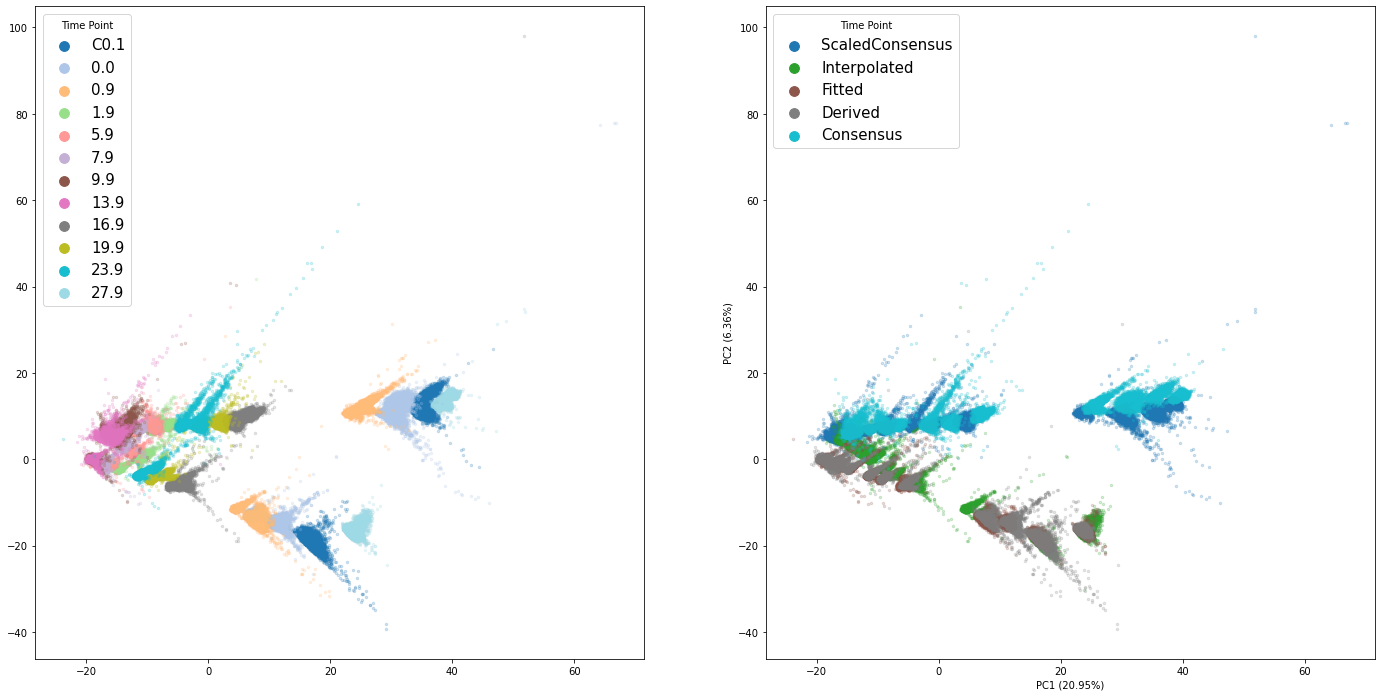

In [27]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn import datasets, preprocessing

dyn_x = norm_chains_df


x = dyn_x.values
x[np.isnan(x)] = 0
x = StandardScaler().fit_transform(x)
# normalised_x = pd.DataFrame(x,columns=norm_dyn_x.iloc[:,4:].columns)


pca_x = PCA()
principalComponents_x = pca_x.fit_transform(x)

print('Explained variation per principal component: {}'.format(pca_x.explained_variance_ratio_))

le = preprocessing.LabelEncoder()

# y = le.fit_transform(norm_chains_df.index.get_level_values("Time")) 
# targets = norm_chains_df.index.get_level_values("Time").unique().to_list() # columnsdyn_x["Time"].unique()

y = le.fit_transform(dyn_x.reset_index()["Time"])
targets = dyn_x.reset_index()["Time"].unique()

# y = le.fit_transform(dyn_x.reset_index()["Equation"])
# targets = dyn_x.reset_index()["Equation"].unique()


# features = norm_chains_df.columns 
features = dyn_x.columns 

cmap = plt.cm.get_cmap('tab20', len(targets))
color_list = [matplotlib.colors.rgb2hex(cmap(i)[:3]) for i in range(cmap.N)]
    
# coordinates of samples (i.e., scores; let's take the first two axes)
scores = principalComponents_x[:, :2]

# coordinates of features (i.e., loadings; note the transpose)
loadings = pca_x.components_[:2].T

# proportions of variance explained by axes
pvars = pca_x.explained_variance_ratio_[:2] * 100

k=len(features)//80
tops = (loadings ** 2).sum(axis=1).argsort()[-k:]
arrows = loadings[tops]
arrows /= np.sqrt((arrows ** 2).sum(axis=0))
arrows *= np.abs(scores).max(axis=0)

fig, axes = plt.subplots(ncols=2,figsize=(24,12))
# plt.figure(figsize=(12, 12))
for i, name in enumerate(targets):
    axes[0].scatter(*zip(*scores[y == i]), label=name, s=6, alpha=0.2,c=color_list[i])
    
legend = axes[0].legend(title='Time Point',fontsize=15,markerscale=4)
[h.set_alpha(1) for h in legend.legendHandles]

# width = -0.0005 * np.min([np.subtract(*plt.xlim()), np.subtract(*plt.ylim())])
# for i, arrow in zip(tops, arrows):
#     plt.arrow(0, 0, *arrow, color='k', alpha=0.75, width=width, ec='none',
#               length_includes_head=True)
#     plt.text(*(arrow * 1.15), features[i], ha='center', va='center')

for i, axis in enumerate('xy'):
    # getattr(plt, f'{axis}ticks')([])
    getattr(plt, f'{axis}label')(f'PC{i + 1} ({pvars[i]:.2f}%)')
    
    
## Take the top 5% of features explaining PC1
print(features[(pca_x.components_[0].T ** 2).argsort()[-len(features)//20:]])

# take the top 5% of all features
print(features[tops])

le = preprocessing.LabelEncoder()

# y = le.fit_transform(norm_chains_df.index.get_level_values("Equation").to_series())
# targets = norm_chains_df.index.get_level_values("Equation").unique().to_list() # norm_chains_df["Equation"].unique()

y = le.fit_transform(dyn_x.index.get_level_values("Equation").to_series())
targets = dyn_x.reset_index()["Equation"].unique()


# features = norm_chains_df.columns 
features = dyn_x.columns

cmap = plt.cm.get_cmap('tab10', len(targets))
color_list = [matplotlib.colors.rgb2hex(cmap(i)[:3]) for i in range(cmap.N)]
    
# coordinates of samples (i.e., scores; let's take the first two axes)
scores = principalComponents_x[:, :2]

# coordinates of features (i.e., loadings; note the transpose)
loadings = pca_x.components_[:2].T

# proportions of variance explained by axes
pvars = pca_x.explained_variance_ratio_[:2] * 100

k=len(features)//80
tops = (loadings ** 2).sum(axis=1).argsort()[-k:]
arrows = loadings[tops]
arrows /= np.sqrt((arrows ** 2).sum(axis=0))
arrows *= np.abs(scores).max(axis=0)

for i, name in enumerate(targets):
    axes[1].scatter(*zip(*scores[y == i]), label=name, s=6, alpha=0.2,c=color_list[i])
    
legend = axes[1].legend(title='Time Point',fontsize=15,markerscale=4)
[h.set_alpha(1) for h in legend.legendHandles]

# width = -0.0005 * np.min([np.subtract(*plt.xlim()), np.subtract(*plt.ylim())])
# for i, arrow in zip(tops, arrows):
#     plt.arrow(0, 0, *arrow, color='k', alpha=0.75, width=width, ec='none',
#               length_includes_head=True)
#     plt.text(*(arrow * 1.15), features[i], ha='center', va='center')

for i, axis in enumerate('xy'):
    # getattr(plt, f'{axis}ticks')([])
    getattr(plt, f'{axis}label')(f'PC{i + 1} ({pvars[i]:.2f}%)')
    
    
## Take the top 5% of features explaining PC1
print(features[(pca_x.components_[0].T ** 2).argsort()[-len(features)//20:]])

# take the top 5% of all features
print(features[tops])

fig.savefig("../results/plots/PCA.png", dpi=300)